# Dataset Expansion

This is the notebook for expanding the intersection dataset (which was calculated and dumped previously in bechdel_intersection.ipynb to get the intersection of CMU dataset & Bechdel dataset). Now, we additionally add the features we need, that are the following:
* Female Cast Ratio
* Sentiment Analysis (neutral, negative, positive)
* Summary Pronoun Density
* Summary Gender Mention Density
* GII ([Source](https://ourworldindata.org/grapher/gender-inequality-index-from-the-human-development-report?tab=chart))
* HDI ([Source](https://ourworldindata.org/grapher/human-development-index))


## Load the intersection & align the following datasets so that they all have matching Wikipedia movie IDs:
* Plot summaries
* Movie metadata with Bechdel intersection
* Characters metadata

In [226]:
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
import json
pd.options.mode.chained_assignment = None
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
from textblob import TextBlob
from scipy.stats import spearmanr
from scipy import stats
import os
import sys
import datetime
import requests
from requests_html import HTML
import statsmodels.formula.api as smf
import plotly.offline as offline
import plotly.figure_factory as ff
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)




movie_metadata = pd.read_csv('MovieSummaries/movie.metadata.tsv',sep='\t')

movie_metadata.columns = ['1. Wikipedia movie ID',
                          '2. Freebase movie ID',
                          '3. Movie name',
                          '4. Movie release date',
                          '5. Movie box office revenue',
                          '6. Movie runtime',
                          '7. Movie languages (Freebase ID:name tuples)',
                          '8. Movie countries (Freebase ID:name tuples)',
                          '9. Movie genres (Freebase ID:name tuples)']

character_metadata = pd.read_csv('MovieSummaries/character.metadata.tsv',sep='\t')

character_metadata.columns = ['1. Wikipedia movie ID',
                              '2. Freebase movie ID',
                              '3. Movie release date',
                              '4. Character name',
                              '5. Actor date of birth',
                              '6. Actor gender',
                              '7. Actor height (in meters)',
                              '8. Actor ethnicity (Freebase ID)',
                              '9. Actor name',
                              '10. Actor age at movie release',
                              '11. Freebase character/actor map ID',
                              '12. Freebase character ID',
                              '13. Freebase actor ID']

movie_metadata_bechdel = pd.read_csv("CMU_bechdel_added.csv")
print(movie_metadata_bechdel.shape)
movie_metadata_bechdel = movie_metadata_bechdel.drop("Unnamed: 0", axis=1)
movie_metadata_bechdel["actor_mention_score"] = pd.Series(np.zeros((movie_metadata_bechdel.shape[0],))) #add the new column

character_metadata_bechdel = character_metadata.copy(deep = True)
print("Characters: Size before:", character_metadata_bechdel.shape)
character_metadata_bechdel = character_metadata_bechdel[character_metadata_bechdel['2. Freebase movie ID'].isin(movie_metadata_bechdel["2. Freebase movie ID"].to_numpy())]
print("Characters: Size after:", character_metadata_bechdel.shape)

print("Movies: Size before:", movie_metadata_bechdel.shape)
movie_metadata_bechdel = movie_metadata_bechdel[movie_metadata_bechdel['2. Freebase movie ID'].isin(character_metadata_bechdel["2. Freebase movie ID"].to_numpy())]
print("Movies: Size after:", movie_metadata_bechdel.shape)

(6521, 11)
Characters: Size before: (450668, 13)
Characters: Size after: (72458, 13)
Movies: Size before: (6521, 11)
Movies: Size after: (6202, 11)


In [227]:
plot_summaries=pd.read_csv('MovieSummaries/plot_summaries.txt', sep='\t', header=None, names=['id', 'plot_summary'])
plot_summaries_bechdel = plot_summaries[plot_summaries['id'].isin(character_metadata_bechdel['1. Wikipedia movie ID'].to_numpy())]

plot_summaries.head()
print(plot_summaries.shape)
print(plot_summaries_bechdel.shape)

print("Movie Metadata Before sync:",movie_metadata_bechdel.shape)
movie_metadata_bechdel = movie_metadata_bechdel[movie_metadata_bechdel['1. Wikipedia movie ID'].isin(plot_summaries_bechdel["id"].to_numpy())]
print("Movie Metadata After sync:",movie_metadata_bechdel.shape)
display(movie_metadata_bechdel)
movie_metadata_bechdel_initial=movie_metadata_bechdel.copy(deep=True)

(42303, 2)
(5194, 2)
Movie Metadata Before sync: (6202, 11)
Movie Metadata After sync: (5194, 11)


,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,actor_mention_score
1,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,0.0
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,0.0
5,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",3,0.0
6,1369204,/m/04x8zs,Juarez,1939,NaN,125.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/04xvh5"": ""Costume drama"", ""/m/03bxz7"": ""B...",2,0.0
7,5664529,/m/0dyy_v,Vixen!,1968,NaN,70.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01yldk"": ""Softcore Porn"", ""/m/06b0n3"": ""S...",3,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6514,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1,0.0
6516,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,0.0
6517,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3,0.0
6519,20244619,/m/04_0j2b,Mirage,1972,NaN,82.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/016wzw"": ""Peru""}","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",3,0.0


# Introduction of Bechdel, what is it? Why is it costly? Can we come up with better approaches?
The Bechdel Test is a simple test to measure the prominence of women in movies. The test consists of three conditions to be satisfied:

1. The cast of the movie contains two women characters,
2. They talk to each other,
3. About a topic besides man

 In our bechdel dataset that we scraped from the web(explanation in readme), we have a categorical score between 0 and 3 for each movie indicating how many tests a single movie passes. We then take the intersection between the cmu movie_metadata and the created bechdel dataset.

Although it seems like a good feature for gender representation, getting the data might be very costly. This is primarily because it involves processing the entire movie script either by humans or complex natural language processing models. In this project, we will introduce new metrics that can be gotten just from the movie summaries, therefore reducing the dramatically the complexity of the latter task. We will then try to see the possible correlations between these metrics and the bechdel score determining the importance of each metric. By doing this, we aim to come up with a new simpler to get formula that may be a better gender representer by combining our new metrics. We will finally observe these new metrics' evolution with each country

## Metric 1:  Actor Mention Density
We calculate the following simple ratio:
$$\frac{number_{female\_characters}}{number_{female\_characters} + number_{male\_characters}}$$

For each unique movie, we access its relative character dataframe and the summary provided. By comparing every name in the summary, we get their genders and calculate the abovementioned score.

In [228]:
def calculate_actor_mention_score(movie_idx):
    movie_summary = plot_summaries_bechdel.iloc[movie_idx]["plot_summary"]
    
    #Tokenize the movie summary
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(movie_summary)
    tokens = [x.lower() for x in tokens]
    tokens_freq = pd.Series(tokens).value_counts(sort=True)
    
    #align movie dataset & character dataset
    movie_id = plot_summaries_bechdel.iloc[movie_idx]["id"]
    character_list = character_metadata_bechdel[character_metadata_bechdel['1. Wikipedia movie ID'] == movie_id][['4. Character name','6. Actor gender']]
    
    character_list_processed = character_list.copy()
    character_list_processed = character_list_processed.dropna()

    #Lowercase character names
    character_list_processed["4. Character name"] = character_list_processed["4. Character name"].str.lower()

    #Split full name and only get the first name
    character_list_processed["4. Character name"] = character_list_processed["4. Character name"].str.split(' ').str[0]

    character_list_processed = character_list_processed.drop(character_list_processed[character_list_processed["4. Character name"] == "the"].index)

    character_gender_stacked = character_list_processed.drop_duplicates(subset='4. Character name', keep=False)
    character_gender_stacked_idx = character_gender_stacked.set_index("4. Character name")

    #Take the intersection between the token's frequency and movie cast
    tokens_intersection = tokens_freq[character_gender_stacked_idx.index.intersection(tokens_freq.index)]
    character_gender_stacked = character_gender_stacked.drop_duplicates()
    character_mention_freq = character_gender_stacked[character_gender_stacked["4. Character name"].isin(tokens_intersection.index)]#.drop_duplicates()

    #Add the number of character mentions in summary to the character meta-dataset
    character_mention_freq["no_mention"] = tokens_intersection.values#pd.DataFrame({'4. Character name':character_mention_freq[0], 'no_mention':character_mention_freq.values})
    character_mention_freq.columns = ["character_name", "gender", "no_mention"]
    character_list_final = character_mention_freq
    #print(character_list_final)
    
    #Group by gender and calculate total number of mentions by gender
    character_list_freq_added = character_list_final.groupby(['gender']).sum()
    if len(character_list_freq_added['no_mention'].index) != 0:
        if character_list_freq_added['no_mention'].shape[0] == 2:
            female_mention, male_mention = character_list_freq_added['no_mention'].iloc[0], character_list_freq_added['no_mention'].iloc[1] #groupby is alphabethic, index 0 = F
            mention_ratio = female_mention/(female_mention + male_mention)
        elif character_list_freq_added['no_mention'].index[0] == "M":
            mention_ratio = 0.
        elif character_list_freq_added['no_mention'].index[0] == "F":
            mention_ratio = 1.
        else:
            mention_ratio = np.nan
    else:
        mention_ratio = np.nan

    actor_mention_score = round(mention_ratio, 4)
    
    return actor_mention_score, movie_id


In [229]:
beginning = time.time()

for a in tqdm(range(movie_metadata_bechdel.shape[0]-1)):
    actor_mention_score, movie_id = calculate_actor_mention_score(a+1)
    
    movie_metadata_bechdel.loc[movie_metadata_bechdel['1. Wikipedia movie ID'] == movie_id, "actor_mention_score"] = actor_mention_score

100%|██████████| 5193/5193 [00:22<00:00, 227.66it/s]


In [230]:
display(movie_metadata_bechdel)

,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,actor_mention_score
1,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,0.2500
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,0.5345
5,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",3,0.2830
6,1369204,/m/04x8zs,Juarez,1939,NaN,125.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/04xvh5"": ""Costume drama"", ""/m/03bxz7"": ""B...",2,NaN
7,5664529,/m/0dyy_v,Vixen!,1968,NaN,70.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01yldk"": ""Softcore Porn"", ""/m/06b0n3"": ""S...",3,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6514,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1,0.7500
6516,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,0.1667
6517,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3,0.5200
6519,20244619,/m/04_0j2b,Mirage,1972,NaN,82.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/016wzw"": ""Peru""}","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",3,NaN


In the barplot below, the simple toddler would see that with increasing actor mention scores, the bechdel score also improves. We will try to see if that correlation is significant in the later steps.

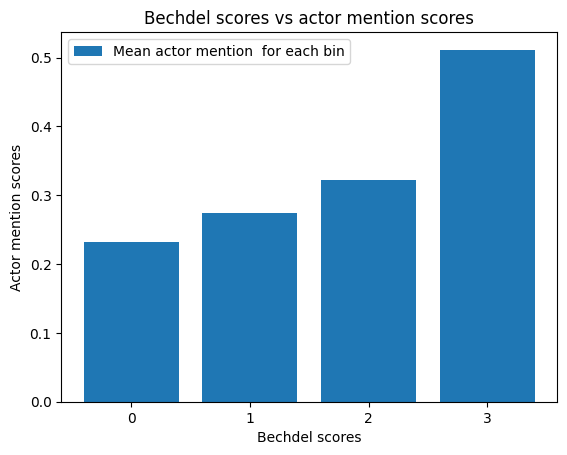

In [231]:
movie_metadata_bechdel=movie_metadata_bechdel.dropna(subset="actor_mention_score")
mention_group=movie_metadata_bechdel.groupby("bechdel_score")["actor_mention_score"].mean()

x=mention_group.index
plt.bar(x, mention_group.values, tick_label=x, label="Mean actor mention  for each bin")
plt.xlabel("Bechdel scores")
plt.ylabel("Actor mention scores")
plt.title("Bechdel scores vs actor mention scores")
plt.legend()
plt.show()

Furthering our analysis, we now plot the distribution again the bechdel score by taking the mean bechdel score of each bin of the actor mention score. Now the correlation is now much more visible and understandable. We have lower bechdel scores for cases where female characters were less mentioned and higher bechdel scores when they are mentioned more.

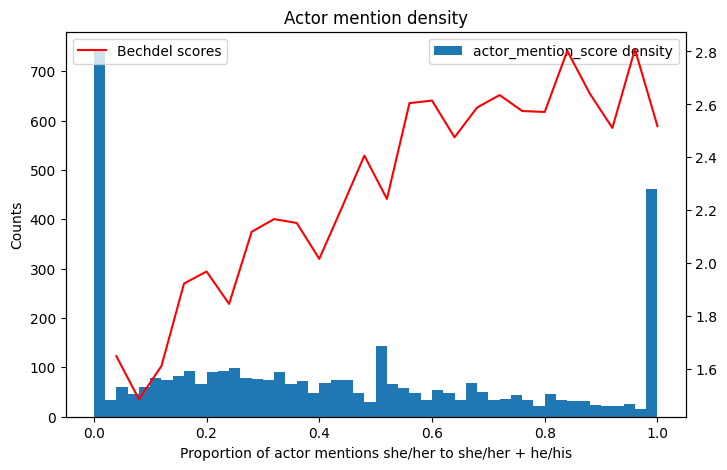

In [268]:
sorted_mentions = movie_metadata_bechdel.sort_values('actor_mention_score')
bins =  np.arange(0, 1.0, 1/25)
ind = np.digitize(sorted_mentions['actor_mention_score'], bins)
    
bechdel_means=sorted_mentions.groupby(ind)["bechdel_score"].mean()

fig, ax= plt.subplots(1,1, figsize=(8,5))
ax.hist(movie_metadata_bechdel["actor_mention_score"], bins=50, label='actor_mention_score density')
ax.set_xlabel("Proportion of actor mentions she/her to she/her + he/his")
ax.set_ylabel("Counts")
ax.set_title("Actor mention density")
ax2 = ax.twinx()
ax2.plot(bechdel_means.index/25,bechdel_means, color='red', label='Bechdel scores')
ax.legend()
ax2.legend()

Now its time for the metric to shine (hopefully). We first do a linear regression using Ordinary Least squares (OLS) between the bechdel score taking it as a dependent variable and taking the actor mention score as an independent variable. We observe an adjusted R squared value of 0.112 which might not seem very high but the probability of observing the regression coefficient is significant for a p value of p=0.01. in fact the system displays it as 0 for two decimal points meaning it is very small that it is rounded down. 

To better understand the correlation we employ the spearman correlation to that also that is not limited by linear correlations. For the latter we get a correlation coefficient of 0.35 which doesn't look bad. However the very small p value that we get is probably from the size effect of the data.

From these analysis we assume that this might be a good metric to predict the bechdel score.

In [233]:
results_mentions = smf.ols('bechdel_score ~ actor_mention_score', data=movie_metadata_bechdel).fit()
print(results_mentions.summary())

spearman_corr_mentions = spearmanr(movie_metadata_bechdel['bechdel_score'], movie_metadata_bechdel['actor_mention_score'])

print(f"Spearman correlation: {spearman_corr_mentions}")

                            OLS Regression Results                            
Dep. Variable:          bechdel_score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     493.1
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          5.43e-103
Time:                        21:42:13   Log-Likelihood:                -5521.4
No. Observations:                3913   AIC:                         1.105e+04
Df Residuals:                    3911   BIC:                         1.106e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.7149    

## Metric 2: Female Cast Ratio

We calculate the female cast ratio, defined by [(Yang et al., 2020)](https://doi.org/10.1145/3411213). This is relatively easy to understand and thus implement. For each movie in our dataset, we get their relative character metadata and calculate the ratio of female to total cast.

In [234]:
unique_count_wiki = character_metadata_bechdel['1. Wikipedia movie ID'].nunique()
unique_count_freebase = character_metadata_bechdel['2. Freebase movie ID'].nunique()
print("Number of unique Wikipedia movie ID values:", unique_count_wiki)
print("Number of unique Freebase movie ID values:", unique_count_freebase)

Number of unique Wikipedia movie ID values: 6202
Number of unique Freebase movie ID values: 6202


In [235]:
#Group by 1. Wikipedia movie ID and 6. Actor gender, then count the occurrences of each gender
gender_counts = character_metadata_bechdel.groupby(['1. Wikipedia movie ID', '6. Actor gender']).size().unstack(fill_value=0)

#Calculate the ratio of female actors to total actors for each movie
gender_counts['female_ratio'] = gender_counts['F'] / (gender_counts['M'] + gender_counts['F'])
gender_counts = gender_counts.reset_index().drop(columns = ["F", "M"])

#merge the gender_counts and character_metadata_bechdel
movie_metadata_bechdel_fcr = pd.merge(movie_metadata_bechdel, gender_counts, on='1. Wikipedia movie ID', how="left")

In [236]:
display(movie_metadata_bechdel_fcr)

,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,actor_mention_score,female_ratio
0,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,0.2500,0.150000
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,0.5345,0.461538
2,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",3,0.2830,0.428571
3,7767613,/m/026ccts,Star!,1968-07-18,4000000.0,176.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/04t36"": ""Musical...",3,1.0000,0.250000
4,1305819,/m/04rjwf,C.H.U.D.,1984-08-31,4650000.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0g092b"": ""Monster movie"", ""/m/06vxwl5"": ""...",2,0.2500,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...
3908,303933,/m/01s7w3,Twister,1996-05-10,494471524.0,113.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/01drsx""...",3,0.2222,0.294118
3909,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1,0.7500,0.235294
3910,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,0.1667,0.454545
3911,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3,0.5200,0.285714


Looking at the distribution below, the standard toddler would see a more linear pattern with increasing female cast ratio. Therefore in first glance, we expect a higher correlation but that's to see later.

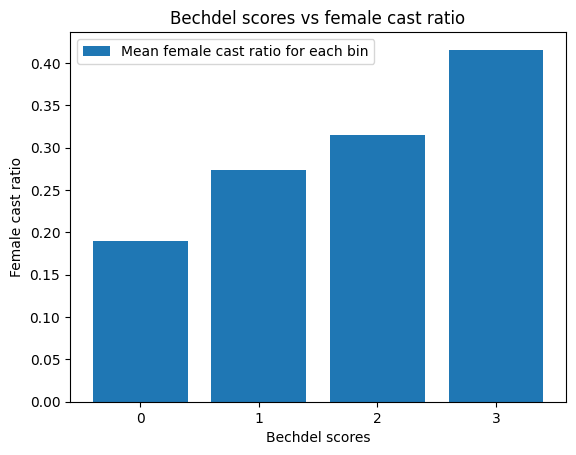

In [237]:
mention_group_fcr=movie_metadata_bechdel_fcr.groupby("bechdel_score")["female_ratio"].mean()

x=mention_group_fcr.index
plt.bar(x, mention_group_fcr.values, tick_label=x, label="Mean female cast ratio for each bin")
plt.xlabel("Bechdel scores")
plt.ylabel("Female cast ratio")
plt.title("Bechdel scores vs female cast ratio")
plt.legend()
plt.show()

### Plotting with the female cast ratio
In this plot, we see the evolution by years the female cast ratio and the bechdel scores. It is apparent that the female cast ratio is much lower than 0.5 meaning there is less casted females than males. To confirm the latter, we apply an independent t test. The results show that the probability of observing a female cast ratio is significantly different (lower in our case) than 0.5. There is indeed more males casted than females :(

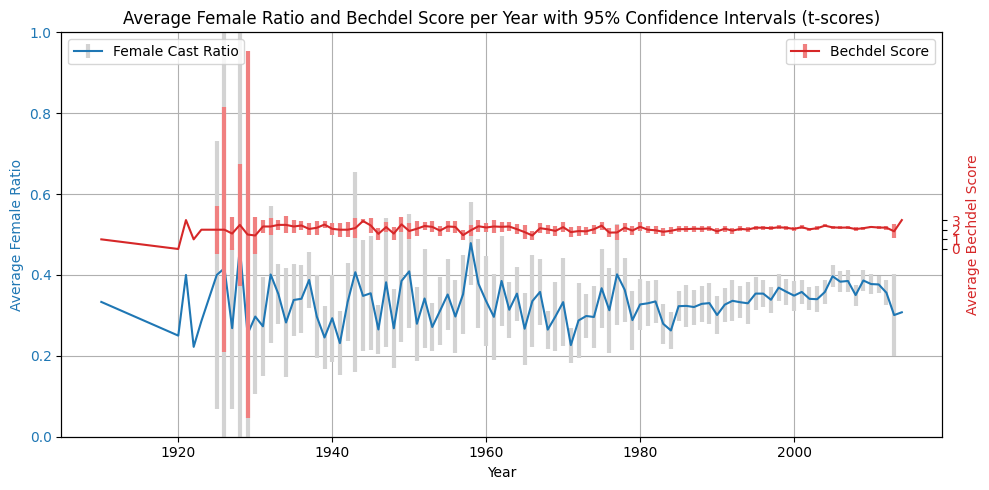

TtestResult(statistic=-54.722463835918695, pvalue=0.0, df=3912)


In [286]:
# Assuming 'bechdel_score' is the column that contains the Bechdel scores
from scipy.stats import sem, t

movie_metadata_bechdel_fcr['year'] = movie_metadata_bechdel_fcr['4. Movie release date'].astype(str).str[:4]
movie_metadata_bechdel_fcr['year']= pd.to_numeric(movie_metadata_bechdel_fcr['year'], errors='coerce')

#Calculate the mean, lower, and upper confidence bounds for female cast ratio
average_female_ratio_per_year = movie_metadata_bechdel_fcr.groupby('year').agg(
    avg_female_ratio=('female_ratio', 'mean'),
    lower_bound=('female_ratio', lambda x: x.mean() - (t.ppf(0.975, x.count()-1) * sem(x))),
    upper_bound=('female_ratio', lambda x: x.mean() + (t.ppf(0.975, x.count()-1) * sem(x)))
).reset_index()

#Calculate the mean, lower, and upper confidence bounds for Bechdel score
average_bechdel_per_year = movie_metadata_bechdel_fcr.groupby('year').agg(
    avg_bechdel_score=('bechdel_score', 'mean'),
    lower_bechdel=('bechdel_score', lambda x: x.mean() - (t.ppf(0.975, x.count()-1) * sem(x))),
    upper_bechdel=('bechdel_score', lambda x: x.mean() + (t.ppf(0.975, x.count()-1) * sem(x)))
).reset_index()

#Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 5))

# lot the female cast ratio on the primary y-axis
ax1.errorbar(average_female_ratio_per_year['year'], average_female_ratio_per_year['avg_female_ratio'], 
             yerr=[average_female_ratio_per_year['avg_female_ratio'] - average_female_ratio_per_year['lower_bound'], 
                   average_female_ratio_per_year['upper_bound'] - average_female_ratio_per_year['avg_female_ratio']],
             fmt='-', label='Female Cast Ratio', ecolor='lightgray', elinewidth=3, capsize=0)
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Female Ratio', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 1) # Assuming female ratio is between 0 and 1
ax1.grid(True)

#Create the secondary y-axis for the Bechdel score
ax2 = ax1.twinx()
ax2.errorbar(average_bechdel_per_year['year'], average_bechdel_per_year['avg_bechdel_score'],
             yerr=[average_bechdel_per_year['avg_bechdel_score'] - average_bechdel_per_year['lower_bechdel'],
                   average_bechdel_per_year['upper_bechdel'] - average_bechdel_per_year['avg_bechdel_score']],
             fmt='-', label='Bechdel Score', ecolor='lightcoral', elinewidth=3, capsize=0, color='tab:red')
ax2.set_ylabel('Average Bechdel Score', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_yticks([0, 1, 2, 3])

plt.title('Average Female Ratio and Bechdel Score per Year with 95% Confidence Intervals (t-scores)')
plt.tight_layout()

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

t_test_fcr = stats.ttest_1samp(movie_metadata_bechdel_fcr["female_ratio"], 0.5)

print(t_test_fcr)

Here the data looks normally distributed. However we observe a similar correlation between the female cast ratio and the bechdel score mean for each bin. This makes sense as well, when more females are casted, they tend to conversate more to each other hence having a higher bechdel score.

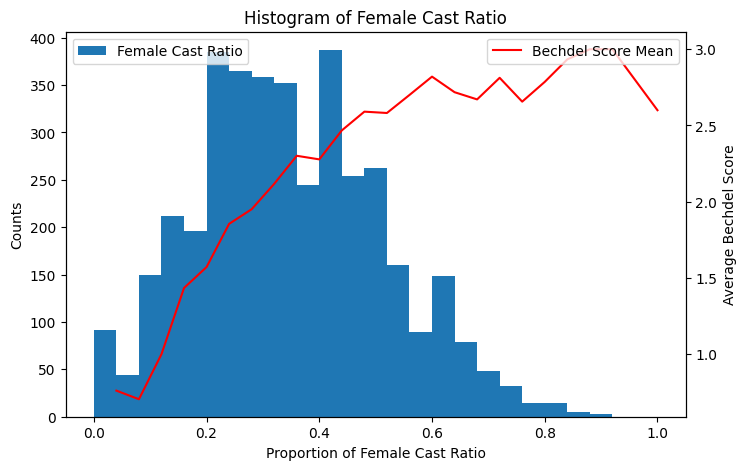

In [274]:
# Sorting the data by female cast ratio
sorted_fcr = movie_metadata_bechdel_fcr.sort_values('female_ratio')

# Creating bins for the female cast ratio
bins = np.arange(0, 1.0, 1/25)
ind = np.digitize(sorted_fcr['female_ratio'], bins)

# Grouping by bins and calculating the mean Bechdel score for each bin
bechdel_means = sorted_fcr.groupby(ind)["bechdel_score"].mean()

# Creating a figure with one subplot
fig, ax = plt.subplots(figsize=(8, 5))

# Plotting the histogram of the female cast ratio
ax.hist(movie_metadata_bechdel_fcr["female_ratio"], bins=bins, label='Female Cast Ratio')

# Setting the x-axis label, y-axis label, and title for the histogram
ax.set_xlabel("Proportion of Female Cast Ratio")
ax.set_ylabel("Counts")
ax.set_title("Histogram of Female Cast Ratio")

# Creating a secondary y-axis for the Bechdel score
ax2 = ax.twinx()

# Plotting the Bechdel scores
ax2.plot(bechdel_means.index/25, bechdel_means, color='red', label='Bechdel Score Mean')

# Setting the y-axis label for the Bechdel scores
ax2.set_ylabel("Average Bechdel Score")

# Adding the legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Displaying the plot
plt.show()

Now its time for the other metric to shine. We do the same OLS linear regression as done with the other metric between the bechdel score taking it as a dependent variable and taking the female cast ratio as an independent variable. We observe an adjusted R squared value of 0.204 which is already higher and the probability of observing the regression coefficient is significant for a p value of p=0.01.

To better understand the correlation we employ the spearman correlation again and we get a significant correlation with a coefficient of 0.46 which is again much higher.
##### It turns out that the simple standard toddler is right!!!

In [240]:
results_fcr = smf.ols('bechdel_score ~ female_ratio', data=movie_metadata_bechdel_fcr).fit()
print(results_fcr.summary())

spearman_corr_fcr = spearmanr(movie_metadata_bechdel_fcr['bechdel_score'], movie_metadata_bechdel_fcr['female_ratio'])

print(f"Spearman correlation: {spearman_corr_fcr}")

                            OLS Regression Results                            
Dep. Variable:          bechdel_score   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     1004.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          2.21e-196
Time:                        21:42:14   Log-Likelihood:                -5306.5
No. Observations:                3913   AIC:                         1.062e+04
Df Residuals:                    3911   BIC:                         1.063e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.1700      0.034     34.318   

## Metric 3: Pronoun Density
Here, we check the density of gender related pronouns in the plot summary we have. After we tokenize the data, we search through the tokens for the frequency of the "she" & "her", compared to frequency of "he" & "him". Then, we simple calculate the following ratio:

$$density_{pronoun} = \frac{number_{she,her}}{number_{she,her} + number_{he,his}}$$

This approach is similar to the first metric but it is more straighforward since it doesn't look for actor names but just at the pronouns.

In [241]:

print(plot_summaries.shape)
tokenizer = RegexpTokenizer(r'\w+')
counts=[{"1. Wikipedia movie ID":0,"she":0, "her":0, "he":0, "his":0} for i in range(plot_summaries.shape[0])]

for i, row in tqdm(plot_summaries.iterrows(), total=plot_summaries.shape[0]):
    tokens = tokenizer.tokenize(row[1])
    counts[i]["1. Wikipedia movie ID"]=row[0]
    counts[i]["she"]=tokens.count("she")
    counts[i]["her"]=tokens.count("her")
    counts[i]["he"]=tokens.count("he")
    counts[i]["his"]=tokens.count("his")

(42303, 2)


  0%|          | 0/42303 [00:00<?, ?it/s]C:\Users\mriza\AppData\Local\Temp\ipykernel_4544\3245972499.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\mriza\AppData\Local\Temp\ipykernel_4544\3245972499.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

100%|██████████| 42303/42303 [00:09<00:00, 4407.58it/s]


In [242]:
genders=pd.DataFrame(counts)
genders["gender_density"]=(genders['she'] + genders['her']) / (genders['she'] + genders['her'] + genders['he'] + genders['his'])
genders_only = genders.drop(columns = ["she", "her", "he", "his"])
movie_metadata_bechdel_fcr_pronoun = pd.merge(movie_metadata_bechdel_fcr, genders, on='1. Wikipedia movie ID', how='left')

display(movie_metadata_bechdel_fcr_pronoun)

,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,actor_mention_score,female_ratio,year,she,her,he,his,gender_density
0,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,0.2500,0.150000,1989.0,0,0,0,1,0.000000
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,0.5345,0.461538,1964.0,7,9,12,20,0.333333
2,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",3,0.2830,0.428571,1989.0,2,4,8,11,0.240000
3,7767613,/m/026ccts,Star!,1968-07-18,4000000.0,176.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/04t36"": ""Musical...",3,1.0000,0.250000,1968.0,13,20,3,2,0.868421
4,1305819,/m/04rjwf,C.H.U.D.,1984-08-31,4650000.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0g092b"": ""Monster movie"", ""/m/06vxwl5"": ""...",2,0.2500,0.285714,1984.0,3,3,1,3,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3908,303933,/m/01s7w3,Twister,1996-05-10,494471524.0,113.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/01drsx""...",3,0.2222,0.294118,1996.0,0,7,2,2,0.636364
3909,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1,0.7500,0.235294,2011.0,4,2,11,12,0.206897
3910,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,0.1667,0.454545,1997.0,1,0,8,9,0.055556
3911,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3,0.5200,0.285714,1988.0,0,6,10,13,0.206897


Hmmmmm... The simple standard toddler might have more difficulties observing a direct correlation at first glance. Let's inspect it further.

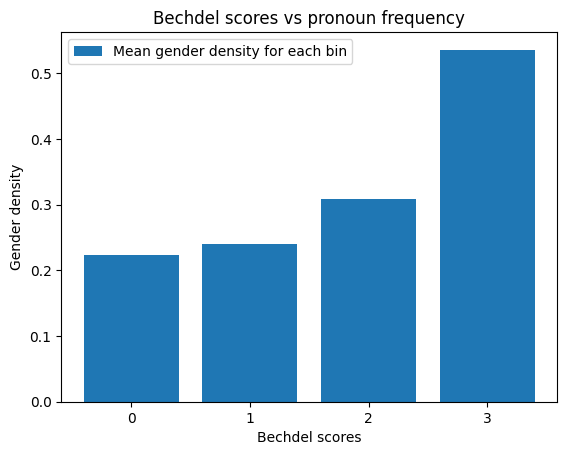

In [243]:
mention_group_pronouns=movie_metadata_bechdel_fcr_pronoun.groupby("bechdel_score")["gender_density"].mean()

x=mention_group_pronouns.index
plt.bar(x, mention_group_pronouns.values, tick_label=x, label="Mean gender density for each bin")
plt.xlabel("Bechdel scores")
plt.ylabel("Gender density")
plt.title("Bechdel scores vs pronoun frequency")
plt.legend()
plt.show()

## What!!!!? Films really mention more males???
Here we first plot the distribution of the pronoun density versus the bechdel score. We can immediately see that a great number of films in the first bin corresponding to a she/her mention of a very low level to 0. When plotting this against the average bechdel test scores for each mean, we observe a visual correlation, meaning for low mentions of females the bechdel score is lower and for mention of females the bechdel score is higher. This result is consistent to what we saw in the beginning of this notebook with the evolution of the female cast ratio over the years. Finally we plot the individual occurences of each pronoun in each plot summary. We then conduct an independent t test telling us that the probability of observing male pronouns versus females are considerably different at a significance level of p=0.01

TtestResult(statistic=-8.659940566312715, pvalue=5.6850155016959634e-18, df=7710.0)


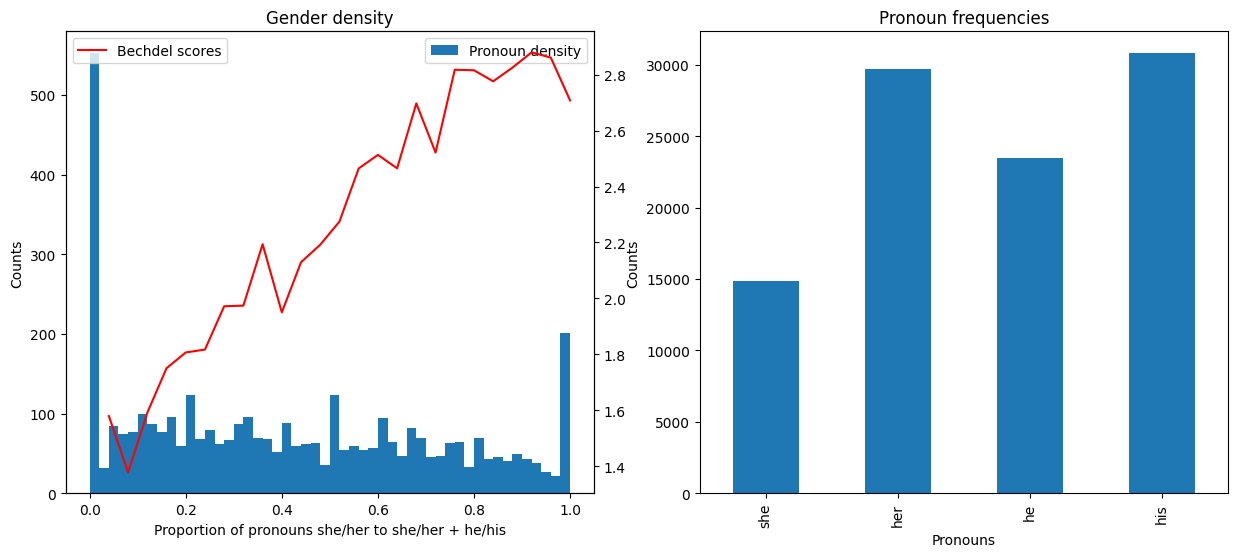

In [279]:
sorted_genders = movie_metadata_bechdel_fcr_pronoun.sort_values('gender_density')
bins =  np.arange(0, 1.0, 1/25)
ind = np.digitize(sorted_genders['gender_density'], bins)
    
bechdel_means=sorted_genders.groupby(ind)["bechdel_score"].mean()

fig, ax= plt.subplots(1,2, figsize=(15,6))
ax[0].hist(movie_metadata_bechdel_fcr_pronoun["gender_density"], bins=50, label='Pronoun density')
ax[0].set_xlabel("Proportion of pronouns she/her to she/her + he/his")
ax[0].set_ylabel("Counts")
ax[0].set_title("Gender density")
ax2 = ax[0].twinx()
ax2.plot(bechdel_means.index/25,bechdel_means, color='red', label='Bechdel scores')
ax[0].legend()
ax2.legend()


genders_sum=movie_metadata_bechdel_fcr_pronoun[["she","her", "he", "his"]].sum()
genders_sum.plot(kind='bar',ax=ax[1])
ax[1].set_xlabel("Pronouns")
ax[1].set_ylabel("Counts")
ax[1].set_title("Pronoun frequencies")

female_pronouns = movie_metadata_bechdel_fcr_pronoun["she"] + movie_metadata_bechdel_fcr_pronoun["her"]
male_pronouns = movie_metadata_bechdel_fcr_pronoun["he"] + movie_metadata_bechdel_fcr_pronoun["his"]

# Perform independent t-test
gender_stats = stats.ttest_ind(female_pronouns, male_pronouns)
print(gender_stats)

The standard toddler may not be right this time, it is a toddler afterall.. The linear regression is still statistically significant with a slightly worse fit with an R squared value of 0.186 than the metric 2. However the spearman correlation coefficient (which is statistically significant at p=0.01) is 0.45 which is less worse than anticipated when comparing the R squared values of the current and the previous metric. The correlation deviates from a linear regime a little bit.

In [245]:
movie_metadata_bechdel_fcr_pronoun=movie_metadata_bechdel_fcr_pronoun.dropna(subset="gender_density")
results_pronoun = smf.ols('bechdel_score ~ gender_density', data=movie_metadata_bechdel_fcr_pronoun).fit()
print(results_pronoun.summary())

spearman_corr_pronoun = spearmanr(movie_metadata_bechdel_fcr_pronoun['bechdel_score'], movie_metadata_bechdel_fcr_pronoun['gender_density'])

print(f"Spearman correlation: {spearman_corr_pronoun}")

                            OLS Regression Results                            
Dep. Variable:          bechdel_score   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     882.9
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          6.97e-175
Time:                        21:42:25   Log-Likelihood:                -5263.9
No. Observations:                3856   AIC:                         1.053e+04
Df Residuals:                    3854   BIC:                         1.054e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.5460      0.025     61.

## Metric 4: Sentiment Analysis

In this section, we obtain the mood of the summary provided, by using the Roberta model, trained on Twitter, and running the model with the tokenized summary. With this method, we do not need the  preprocessing of our summary, such as stop-word-removal, etc. In return, we get the probabilities of the following three moods:
1. Negative
2. Neutral
3. Positive

In [246]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)


scores_final=[]
for i, row in tqdm(plot_summaries.iterrows(), total=plot_summaries.shape[0]):
    encoded_text = tokenizer(row[1], return_tensors='pt', truncation=True, max_length=512).to(device)

    output = model(**encoded_text)

    scores = output[0][0].detach().cpu().numpy()

    scores = softmax(scores)

    scores_dict = {
        'index': row[0],
        'negative': scores[0],
        'neutral': scores[1],
        'positive': scores[2]
    }
    scores_final.append(scores_dict)
    
sentiments=scores_final.copy()
sentiments=pd.DataFrame(sentiments)
sentiments.to_csv("sentiment_analysis.csv", index=False)
sentiments=pd.read_csv("sentiment_analysis.csv")

## Oh man! That movie was really sentimental! Or is it?

When we plot the sentiment analysis results for all the movies in our initial cmu dataset, we clearly see that neutral movies make the substantial majority with the negative movies coming in for the second place and the positive movies for the last. Although the difference is visually very visible, we nevertheless perform a t test. As a result we see that the probability of having neutral scores are statistically different than observing a positive or a negative score at a significance level of p=0.01 

TtestResult(statistic=480.7956324949688, pvalue=0.0, df=84604.0)
TtestResult(statistic=165.7254445862797, pvalue=0.0, df=84604.0)


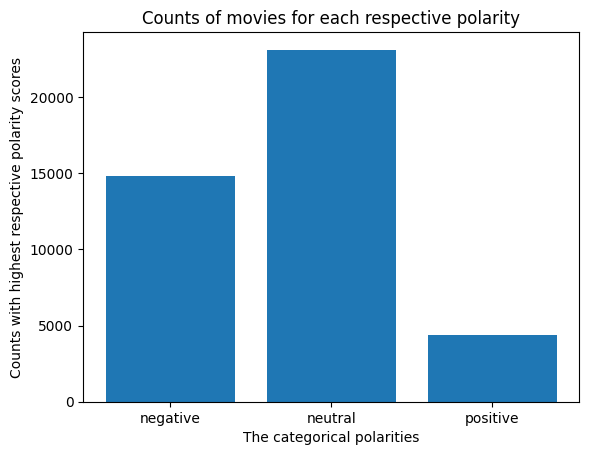

In [247]:
sentiments=sentiments.dropna()
sentiment_counts = sentiments[["negative", "neutral", "positive"]].sum()
plt.bar(["negative","neutral","positive"], sentiment_counts.values)
plt.xlabel("The categorical polarities")
plt.ylabel("Counts with highest respective polarity scores")
plt.title("Counts of movies for each respective polarity")

neu_pos = stats.ttest_ind(sentiments["neutral"], sentiments["positive"])
print(neu_pos)
neu_neg = stats.ttest_ind(sentiments["neutral"], sentiments["negative"])
print(neu_neg)

### Getting the polarity scores from text_blob
Since the roberta model only gives categorical scores that add up to 1 and not the polarity score, we will calculate the roberta polarity by substracting the negative score from the positive score. But first to set a baseline for our approach we calculate directly the polarity scores by using the library Textblob, the roberta polarity will be calculated after.

In [248]:
polarity_scores_final=[]
for i, row in tqdm(plot_summaries.iterrows(), total=plot_summaries.shape[0]):
    #print(i)
    blob=TextBlob(row[1])
    polarity_scores = {
        'index': row[0],
        'sentiment_polarity_blob': blob.sentiment[0],
    }
    polarity_scores_final.append(polarity_scores)

polarities=polarity_scores_final.copy()
polarities=pd.DataFrame(polarity_scores_final)
polarities.to_csv("polarities.csv", index=False)


  0%|          | 0/42303 [00:00<?, ?it/s]C:\Users\mriza\AppData\Local\Temp\ipykernel_4544\3081513322.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\mriza\AppData\Local\Temp\ipykernel_4544\3081513322.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

100%|██████████| 42303/42303 [01:03<00:00, 671.48it/s] 


In [249]:
display(polarities)

,index,sentiment_polarity_blob
0,23890098,0.200000
1,31186339,0.045261
2,20663735,0.049550
3,2231378,0.030550
4,595909,0.063913
...,...,...
42298,34808485,0.146667
42299,1096473,0.155081
42300,35102018,0.156000
42301,8628195,0.104762


Below we merge our textblob and roberta results with the intersection dataset with bechdel, we also do calculate the Roberta Polarities as indicated above

In [250]:
sentiments_sync = sentiments[sentiments["index"].isin(movie_metadata_bechdel_fcr_pronoun["1. Wikipedia movie ID"])]
sentiments_sync.columns = ["1. Wikipedia movie ID", "negative", "neutral", "positive"]
movie_metadata_bechdel_fcr_pronoun_sentiment = pd.merge(movie_metadata_bechdel_fcr_pronoun, sentiments_sync, on='1. Wikipedia movie ID', how="left")
print("After sentiment scores added:",movie_metadata_bechdel_fcr_pronoun.shape)

polarities_sync = polarities[polarities["index"].isin(movie_metadata_bechdel_fcr_pronoun_sentiment["1. Wikipedia movie ID"])]
polarities_sync.columns = ["1. Wikipedia movie ID", "polarity_blob"]
movie_metadata_bechdel_fcr_pronoun_sentiment = pd.merge(movie_metadata_bechdel_fcr_pronoun_sentiment, polarities_sync, on='1. Wikipedia movie ID', how="left")
movie_metadata_bechdel_fcr_pronoun_sentiment["polarity_roberta"]=movie_metadata_bechdel_fcr_pronoun_sentiment["positive"]-movie_metadata_bechdel_fcr_pronoun_sentiment["negative"]

movie_metadata_bechdel_fcr_pronoun_sentiment=movie_metadata_bechdel_fcr_pronoun_sentiment.dropna(subset=["bechdel_score", "actor_mention_score", "polarity_blob", "polarity_roberta", "gender_density"])
display(movie_metadata_bechdel_fcr_pronoun_sentiment)


After sentiment scores added: (3856, 18)


,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,...,she,her,he,his,gender_density,negative,neutral,positive,polarity_blob,polarity_roberta
0,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,...,0,0,0,1,0.000000,0.048826,0.830560,0.120614,-0.006250,0.071788
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,...,7,9,12,20,0.333333,0.129004,0.691920,0.179076,0.124547,0.050073
2,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",3,...,2,4,8,11,0.240000,0.252773,0.634228,0.112999,0.103638,-0.139774
3,7767613,/m/026ccts,Star!,1968-07-18,4000000.0,176.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/04t36"": ""Musical...",3,...,13,20,3,2,0.868421,0.331542,0.582415,0.086043,0.045837,-0.245499
4,1305819,/m/04rjwf,C.H.U.D.,1984-08-31,4650000.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0g092b"": ""Monster movie"", ""/m/06vxwl5"": ""...",2,...,3,3,1,3,0.600000,0.640489,0.336088,0.023423,-0.049902,-0.617066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3851,303933,/m/01s7w3,Twister,1996-05-10,494471524.0,113.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/01drsx""...",3,...,0,7,2,2,0.636364,0.333736,0.607674,0.058590,0.090317,-0.275146
3852,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1,...,4,2,11,12,0.206897,0.384289,0.565830,0.049881,0.041294,-0.334408
3853,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,...,1,0,8,9,0.055556,0.131713,0.691487,0.176800,0.094097,0.045087
3854,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3,...,0,6,10,13,0.206897,0.317630,0.585357,0.097013,0.062872,-0.220617


#### Roberta vs Blob Polarities

One interesting thing about our calculated roberta metric is that it doesn't account for the neutral so it tends to jiggle around a lot whereas the blob model is a better representation of polarity since the resulting normal distribution is around 0 which makes sense since the Roberta model predicted that the majority of the movies had higher neutral scores. As seen in the interactive plot below, the roberta polarity tends to be centered around a negative value. Given our hypothesis that the blob model might more robust, we will analyze it further more.

In [251]:
x = movie_metadata_bechdel_fcr_pronoun_sentiment["polarity_blob"]
y = movie_metadata_bechdel_fcr_pronoun_sentiment["polarity_roberta"]

colorscale = ['#7A4579', '#D56073', 'rgb(236,158,105)', (1, 1, 0.2), (0.98,0.98,0.98)]

fig = ff.create_2d_density(
    x, y, colorscale=colorscale,
    hist_color='rgb(255, 237, 222)', point_size=3
)

fig.update_layout(
    xaxis_title="Blob polarity",
    yaxis_title="Roberta polarity"
)

offline.iplot(fig, filename='histogram_subplots.png')
fig.write_html("polarities.html")

We now analyze the correlation between various polarities between each other and between the bechdel scores. Significant correlation is observed between the two polarities as expected with a spearman correlation coefficient of 0.41. When it comes to the comparaison of the two polarity scores and the bechdel score, both the regression coefficients and the spearman coefficients are significant witht he spearman correlation coefficients both around 0.10. We will include this as a metric in the final part of our notebook, however we will use the blob polarity.

In [252]:
#movie_metadata_bechdel_fcr_pronoun=movie_metadata_bechdel_fcr_pronoun.dropna(subset="gender_density")
results_polarities = smf.ols('polarity_roberta ~ polarity_blob', data=movie_metadata_bechdel_fcr_pronoun_sentiment).fit()
print(results_polarities.summary())

spearman_corr_polarities = spearmanr(movie_metadata_bechdel_fcr_pronoun_sentiment['polarity_roberta'], movie_metadata_bechdel_fcr_pronoun_sentiment['polarity_blob'])

print(f"Spearman correlation: {spearman_corr_polarities}")

results_blob = smf.ols('bechdel_score ~ polarity_blob', data=movie_metadata_bechdel_fcr_pronoun_sentiment).fit()
print(results_blob.summary())

spearman_corr_blob = spearmanr(movie_metadata_bechdel_fcr_pronoun_sentiment['bechdel_score'], movie_metadata_bechdel_fcr_pronoun_sentiment['polarity_blob'])

print(f"Spearman correlation: {spearman_corr_blob}")

results_roberta = smf.ols('bechdel_score ~ polarity_roberta', data=movie_metadata_bechdel_fcr_pronoun_sentiment).fit()
print(results_roberta.summary())

spearman_corr_roberta = spearmanr(movie_metadata_bechdel_fcr_pronoun_sentiment['bechdel_score'], movie_metadata_bechdel_fcr_pronoun_sentiment['polarity_roberta'])

print(f"Spearman correlation: {spearman_corr_roberta}")

                            OLS Regression Results                            
Dep. Variable:       polarity_roberta   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     831.1
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          1.14e-165
Time:                        21:43:28   Log-Likelihood:                 1142.2
No. Observations:                3856   AIC:                            -2280.
Df Residuals:                    3854   BIC:                            -2268.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.2891      0.003    -91.282

### The light at the end of the tunnel is seen, lets put all the correlation coefficients together!

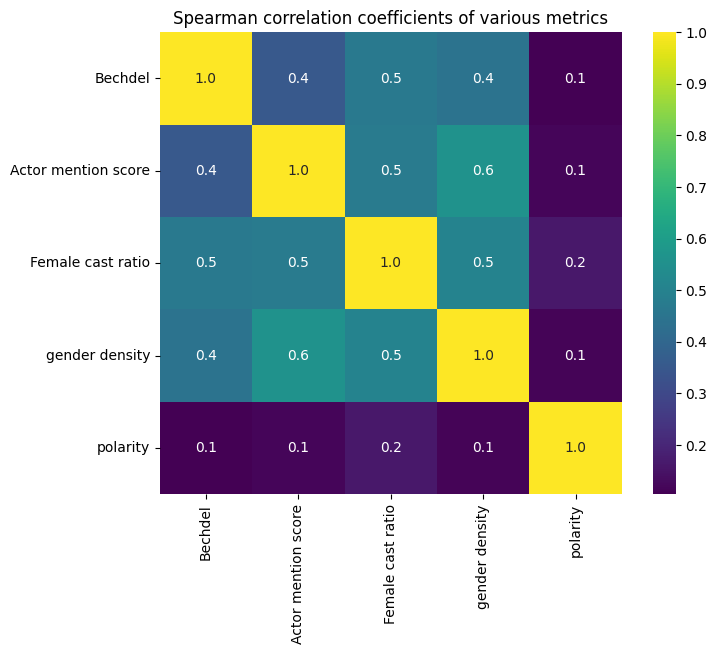

In [253]:
spearman_corr_fgr_mention = spearmanr(movie_metadata_bechdel_fcr_pronoun_sentiment['female_ratio'], movie_metadata_bechdel_fcr_pronoun_sentiment['actor_mention_score'])
spearman_corr_pronoun_mention = spearmanr(movie_metadata_bechdel_fcr_pronoun_sentiment['gender_density'], movie_metadata_bechdel_fcr_pronoun_sentiment['actor_mention_score'])
spearman_corr_polarity_mention = spearmanr(movie_metadata_bechdel_fcr_pronoun_sentiment['polarity_blob'], movie_metadata_bechdel_fcr_pronoun_sentiment['actor_mention_score'])
spearman_corr_fgr_pronoun = spearmanr(movie_metadata_bechdel_fcr_pronoun_sentiment['female_ratio'], movie_metadata_bechdel_fcr_pronoun_sentiment['gender_density'])
spearman_corr_fgr_polarity = spearmanr(movie_metadata_bechdel_fcr_pronoun_sentiment['female_ratio'], movie_metadata_bechdel_fcr_pronoun_sentiment['polarity_blob'])
spearman_corr_pronoun_polarity = spearmanr(movie_metadata_bechdel_fcr_pronoun_sentiment['gender_density'], movie_metadata_bechdel_fcr_pronoun_sentiment['polarity_blob'])
correlations = np.array([
    [1.0, spearman_corr_mentions[0], spearman_corr_fcr[0], spearman_corr_pronoun[0], spearman_corr_blob[0]],  # Correlations for A
    [spearman_corr_mentions[0], 1, spearman_corr_fgr_mention[0], spearman_corr_pronoun_mention[0], spearman_corr_polarity_mention[0]],  # Correlations for B
    [spearman_corr_fcr[0],spearman_corr_fgr_mention[0], 1.0, spearman_corr_fgr_pronoun[0], spearman_corr_fgr_polarity[0]],  # Correlations for C
    [spearman_corr_pronoun[0], spearman_corr_pronoun_mention[0], spearman_corr_fgr_pronoun[0], 1.0, spearman_corr_pronoun_polarity[0]],  # Correlations for D
    [spearman_corr_blob[0], spearman_corr_polarity_mention[0], spearman_corr_fgr_polarity[0], spearman_corr_pronoun_polarity[0], 1.0]   # Correlations for E
])

# Variables (labels)
variables = ["Bechdel", "Actor mention score", "Female cast ratio", "gender density", "polarity"]

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, fmt=".1f", cmap="viridis", square=True, 
            xticklabels=variables, yticklabels=variables)
plt.title("Spearman correlation coefficients of various metrics")
plt.show()

## One last thing: Box Office Scraping, where the hell did all the data go???
**We decided to put this part at the end since initially we wanted to see if we could use the box office as a metric. However for the reasons that will be explained below, we decided not to.**

To analyse how Bechdel and other woman representation metrics evolved in time with their relevancy towards the industry, box office revenue data is important to consider. However after our initial inspection of the Bechdel intersection dataset in P2, we discovered that only around 45% of the data had box office revenue making it the movie characteristic in CMU with the highest percentage of missing data. We concluded that we need at least 60% of movie information to include box office revenue for a stronger analysis. Therefore, we decided to scrape box office data from https://www.boxofficemojo.com/ to expand our dataframe.

The scraping algorithm was created based on the online tutorial: https://github.com/codingforentrepreneurs/30-Days-of-Python/tree/master/tutorial-reference/Day%2012  The algorithm was adapted to create a single dataframe of all years of box office rather than separate csv files for each year. 

In [254]:
def url_to_txt(url, filename="world.html", save=False):
    r = requests.get(url)
    if r.status_code == 200:
        html_text = r.text
        if save:
            with open(f"world-{year}.html", 'w') as f:
                f.write(html_text)
        return html_text
    return None

def parse_and_extract(url, name):
    html_text = url_to_txt(url)
    if html_text == None:
        #print(f"{name} not finished")
        return None
    r_html = HTML(html=html_text)
    table_class = ".imdb-scroll-table"
    r_table = r_html.find(table_class)

    table_data = []
    table_data_dicts = []
    header_names = []
    if len(r_table) == 0:
        return False
    parsed_table = r_table[0]
    rows = parsed_table.find("tr")
    header_row = rows[0]
    header_cols = header_row.find('th')
    header_names = [x.text for x in header_cols]
    for row in rows[1:]:
        cols = row.find("td")
        row_data = []
        row_dict_data = {}
        for i, col in enumerate(cols):
            header_name = header_names[i]
            row_data.append(col.text)
        table_data_dicts.append(row_dict_data)
        table_data.append(row_data)
    df = pd.DataFrame(table_data, columns=header_names)

    return df

def run(start_year, years_ago=0):
    
    df_box_office = pd.DataFrame()
    
    for i in tqdm(range(0, years_ago+1)):
        url = f"https://www.boxofficemojo.com/year/world/{start_year}/"
        #print(f"\ndataframe for year {start_year} is\n")
        
        df = parse_and_extract(url, name=start_year)
            
        df_box_office = pd.concat([df_box_office, df], axis=0)
        start_year += 1
        
    print("\nthe resulted box office dataframe is:")
    display(df_box_office)
    return df_box_office
        

if __name__ == "__main__":
    start=1970 #the boxofficemojo website only has information starting this date
    count=45 #count until the release year of movies in Bechdel intersection dataframe which we consider around 2015
    df_box_office = run(start_year=start, years_ago=count) #dataframe reated that only contain scraped box office information

df_box_office.to_csv("box_office.csv", index=False)

' def url_to_txt(url, filename="world.html", save=False):\n    r = requests.get(url)\n    if r.status_code == 200:\n        html_text = r.text\n        if save:\n            with open(f"world-{year}.html", \'w\') as f:\n                f.write(html_text)\n        return html_text\n    return None\n\ndef parse_and_extract(url, name):\n    html_text = url_to_txt(url)\n    if html_text == None:\n        #print(f"{name} not finished")\n        return None\n    r_html = HTML(html=html_text)\n    table_class = ".imdb-scroll-table"\n    r_table = r_html.find(table_class)\n\n    table_data = []\n    table_data_dicts = []\n    header_names = []\n    if len(r_table) == 0:\n        return False\n    parsed_table = r_table[0]\n    rows = parsed_table.find("tr")\n    header_row = rows[0]\n    header_cols = header_row.find(\'th\')\n    header_names = [x.text for x in header_cols]\n    for row in rows[1:]:\n        cols = row.find("td")\n        row_data = []\n        row_dict_data = {}\n        for 

We created a new dataframe with more box office revenue information in the column "5. Movie box office revenue". If originally, there is a NaN value in this column and there is a value that was found based on the scraped information, it will be added. 

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)
bechdel_score
actor_mention_score
%.1


[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5'),
 Text(5, 0, '6'),
 Text(6, 0, '7'),
 Text(7, 0, '8'),
 Text(8, 0, '9'),
 Text(9, 0, '10'),
 Text(10, 0, '11'),
 Text(11, 0, '12')]

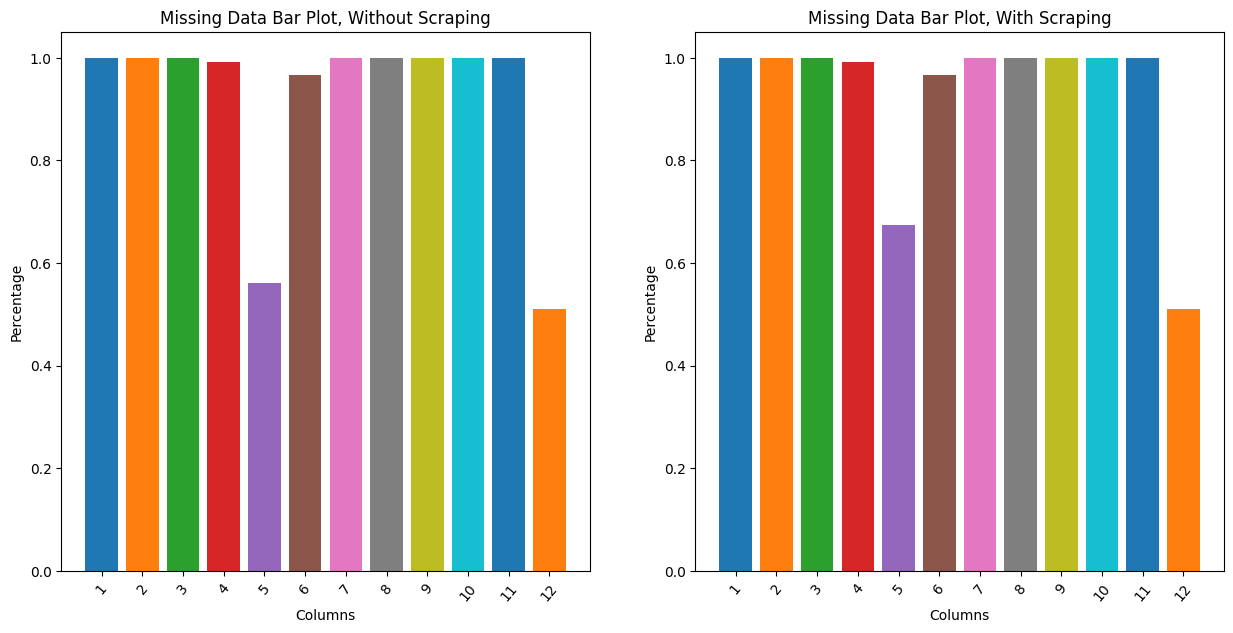

In [255]:
#change the name of movie name column to match our bechdel intersection dataframe
df_box_office=pd.read_csv("box_office.csv")
df_box_office.rename(columns={'Release Group': '3. Movie name'}, inplace=True)

# Drop unnecessary columns
df_box_office = df_box_office.drop(['Rank', '%', '%', 'Domestic', 'Foreign'], axis=1)

# Merge based on the 'ID' column
merged_df = pd.merge(movie_metadata_bechdel_initial, df_box_office, on='3. Movie name', how='left')

updated_df = merged_df.copy(deep=True)

# Fill NaN values in '5. Movie box office revenue' with values from 'Worldwide' which is the scraped data information
updated_df['5. Movie box office revenue'] = updated_df['5. Movie box office revenue'].fillna(updated_df['Worldwide'])

merged_df = merged_df.drop('Worldwide',axis=1)
updated_df = updated_df.drop('Worldwide',axis=1)

# Indicator variable showing that something is NA
df_analysis=merged_df.copy(deep=True)
df_analysis["4. Movie release date"]=df_analysis["4. Movie release date"].dropna().astype(str).str[:4]

df_analysis_bechdel=updated_df.copy(deep=True)
df_analysis_bechdel["4. Movie release date"]=df_analysis_bechdel["4. Movie release date"].dropna().astype(str).str[:4]

columns_list=df_analysis.columns
fig,ax= plt.subplots(1,2, figsize=(15,7))


for column_name, index in zip(columns_list, range(0, len(columns_list))):
    print(column_name)

    df_analysis["missing_data"] = df_analysis[column_name].notna()
    mean_missing=df_analysis["missing_data"].mean()

    df_analysis_bechdel["missing_data"] = df_analysis_bechdel[column_name].notna()
    mean_missing_bechdel=df_analysis_bechdel["missing_data"].mean()


    ax[0].bar(column_name,mean_missing)
    ax[1].bar(column_name,mean_missing_bechdel)

ax[0].set_ylabel("Percentage")
ax[0].set_xlabel("Columns")
ax[0].set_title(f"Missing Data Bar Plot, Without Scraping")
ticks = ax[0].get_xticks();  # Get the current tick positions
ax[0].set_xticks(ticks)
ticks = [s+1 for s in ticks]
ax[0].set_xticklabels(ticks, rotation = 50)

ax[1].set_ylabel("Percentage")
ax[1].set_xlabel("Columns")
ax[1].set_title(f"Missing Data Bar Plot, With Scraping")
ticks = ax[1].get_xticks();  # Get the current tick positions
ax[1].set_xticks(ticks)
ticks = [s+1 for s in ticks]
ax[1].set_xticklabels(ticks, rotation = 50)

We see that neither of the linear regression coefficients are statistically significant at p=0.01, therefore we decide not to include the box office data in our metric. Even if the relation is not exactly linear, we would have expected lower p values.

In [262]:
#update the dataframe with scraped box office data and filter the box office column for clean float values
df_box_office_analysis = pd.merge(movie_metadata_bechdel_fcr_pronoun_sentiment, df_box_office, on='3. Movie name', how='left')
df_box_office_analysis['5. Movie box office revenue'] = df_box_office_analysis['5. Movie box office revenue'].fillna(df_box_office_analysis['Worldwide'])
df_box_office_analysis['5. Movie box office revenue'] = (df_box_office_analysis['5. Movie box office revenue'].dropna())
df_box_office_analysis['5. Movie box office revenue'] = df_box_office_analysis['5. Movie box office revenue'].str.replace('$', '')
df_box_office_analysis['5. Movie box office revenue'] = df_box_office_analysis['5. Movie box office revenue'].str.replace(',', '')


#change the column name of box office revenue with underscore so the linear regression can be conducted
df_box_office_analysis.rename(columns={'5. Movie box office revenue': 'Movie_box_office_revenue'}, inplace=True)

#change the column of box office data from string to numbers
df_box_office_analysis['Movie_box_office_revenue'] = df_box_office_analysis['Movie_box_office_revenue'].astype(float)

results1 = smf.ols('Movie_box_office_revenue ~ bechdel_score', data=df_box_office_analysis).fit()
results2 = smf.ols('Movie_box_office_revenue ~ gender_density', data=df_box_office_analysis).fit()
results3 = smf.ols('Movie_box_office_revenue ~ actor_mention_score', data=df_box_office_analysis).fit()
results4 = smf.ols('Movie_box_office_revenue ~ female_ratio', data=df_box_office_analysis).fit()
print(results1.summary())
print(results2.summary())
print(results3.summary())
print(results4.summary())

                               OLS Regression Results                               
Dep. Variable:     Movie_box_office_revenue   R-squared:                       0.006
Model:                                  OLS   Adj. R-squared:                  0.003
Method:                       Least Squares   F-statistic:                     2.007
Date:                      Fri, 22 Dec 2023   Prob (F-statistic):              0.157
Time:                              21:47:34   Log-Likelihood:                -6960.6
No. Observations:                       338   AIC:                         1.393e+04
Df Residuals:                           336   BIC:                         1.393e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

## Auxililary Features

We added the binary bechdel test for further analysis.

In [256]:
movie_metadata_bechdel_fcr_pronoun_sentiment["bechdel_binary"] = (movie_metadata_bechdel_fcr_pronoun_sentiment["bechdel_score"] == 3).astype(int)

In [257]:
display(movie_metadata_bechdel_fcr_pronoun_sentiment)

,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,...,her,he,his,gender_density,negative,neutral,positive,polarity_blob,polarity_roberta,bechdel_binary
0,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",3,...,0,0,1,0.000000,0.048826,0.830560,0.120614,-0.006250,0.071788,1
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",3,...,9,12,20,0.333333,0.129004,0.691920,0.179076,0.124547,0.050073,1
2,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",3,...,4,8,11,0.240000,0.252773,0.634228,0.112999,0.103638,-0.139774,1
3,7767613,/m/026ccts,Star!,1968-07-18,4000000.0,176.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/04t36"": ""Musical...",3,...,20,3,2,0.868421,0.331542,0.582415,0.086043,0.045837,-0.245499,1
4,1305819,/m/04rjwf,C.H.U.D.,1984-08-31,4650000.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0g092b"": ""Monster movie"", ""/m/06vxwl5"": ""...",2,...,3,1,3,0.600000,0.640489,0.336088,0.023423,-0.049902,-0.617066,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3851,303933,/m/01s7w3,Twister,1996-05-10,494471524.0,113.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/01drsx""...",3,...,7,2,2,0.636364,0.333736,0.607674,0.058590,0.090317,-0.275146,1
3852,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1,...,2,11,12,0.206897,0.384289,0.565830,0.049881,0.041294,-0.334408,0
3853,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,...,0,8,9,0.055556,0.131713,0.691487,0.176800,0.094097,0.045087,1
3854,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",3,...,6,10,13,0.206897,0.317630,0.585357,0.097013,0.062872,-0.220617,1


In [258]:
#Dump final dataset to csv file
movie_metadata_bechdel_fcr_pronoun_sentiment.to_csv("movie_metadata_all_features.csv", index=False)

## Bechdel Analysis: GII & HDI Addition

To further analyze the dataset and relations with Bechdel score, we introduce Gender Inequality Index (GII) and Human Development Index (HDI) to our dataset. This way, we can carry out an analysis based on the countries.
([Source for GII](https://ourworldindata.org/grapher/gender-inequality-index-from-the-human-development-report?tab=chart))
([Source for HDI](https://ourworldindata.org/grapher/human-development-index))

In [280]:
# Load Data
bechdel_movies = pd.read_csv('CMU_bechdel_added.csv')

GII = pd.read_csv('gender-inequality-index-from-the-human-development-report.csv')
HDI = pd.read_csv('human-development-index.csv')

#Add Country Names
bechdel_movies['country_names'] = bechdel_movies['8. Movie countries (Freebase ID:name tuples)'].apply(
    lambda x: list(json.loads(x).values()))

# If some movie is created in diferent countries it will create new rows for each country 
bechdel_movies = bechdel_movies.explode('country_names')

# Group by Country
grouped_by_country = bechdel_movies.groupby('country_names').size().sort_values().reset_index(name="Movie Count")

# Just show if the country have more then 20 movies
filt_grouped_by_country = grouped_by_country[grouped_by_country['Movie Count']>20]


#TAKE OUT MOVIES WITHOUT RELEASE DATE OR/AND COUNTRY
# Bechdel Test and GII, we need to take out the data that doesn't have country or date of release
bechdel_movies_filt = bechdel_movies[~(bechdel_movies['4. Movie release date'].isnull() | 
                                       (bechdel_movies['8. Movie countries (Freebase ID:name tuples)'] == '{}'))]

print("\nWe pass from " + str(len(bechdel_movies['1. Wikipedia movie ID'].unique())) + ' movies to '+ 
      str(len(bechdel_movies_filt['1. Wikipedia movie ID'].unique())) + " movies that don't have release date or country." )

# Take off the nan values and just see the first 4 numbers (years)
bechdel_movies_filt['Year'] = bechdel_movies_filt['4. Movie release date'].astype(str).str[:4]
bechdel_movies_filt['Year'] = bechdel_movies_filt['Year'].astype(int)

# Verifications
# movies_inside_HDIGII = bechdel_movies_filt[bechdel_movies_filt['Year']>=1990]
# print(len(movies_inside_HDIGII))
# print(len(movies_inside_HDIGII['1. Wikipedia movie ID'].unique()))

# Combine the HDI and GII dataframes
merge_HDI_GII = pd.merge(HDI, GII, on = ['Entity','Year','Code'], how = 'left')
merge_HDI_GII['Year'] = merge_HDI_GII['Year'].astype(int)
merge_HDI_GII['Entity'] = merge_HDI_GII['Entity'].replace('United States','United States of America')

bechdel_movies_filt = bechdel_movies_filt.rename(columns = {'country_names': 'Entity'})

# Add the Code on bechdel_movies_filt
df_entityCode = merge_HDI_GII.loc[:,('Entity','Code')]
df_entityCode = df_entityCode.drop_duplicates(['Entity','Code'])
df_entityCode['Entity'] = df_entityCode['Entity'].replace('United States','United States of America')
merged = pd.merge(bechdel_movies_filt,df_entityCode, on = ['Entity'], how='left')

# Print how many movies don't have Code 
nan_countries = merged[merged['Code'].isna()]
nan_countries_n = nan_countries['Entity'].unique()
nan_countries_movies = nan_countries['1. Wikipedia movie ID'].unique()

print("\nThere is " + str(len(nan_countries_n)) + ' countries that are not inside the Dataframe HDI and GII:')
print(nan_countries_n)
print('Corresponding to ' + str(len(nan_countries_movies)) + ' movies')

# Drop the movies that dont have data on merge_HDI_GII
merged = merged[~(merged['Code'].isna())]

# Merge the Bechdel Test with HDI and GII
merged_data = pd.merge(merged, merge_HDI_GII, on = ['Year','Entity','Code'], how = 'left')

# The out the nan from HDI or GII
final = merged_data[(~merged_data['Human Development Index'].isna())|(~merged_data['Gender Inequality Index'].isna())]

# To know how mutch movies have one or both metrics(HDI and/or GII)
n_final_movies = final['1. Wikipedia movie ID'].unique()
print("\nThere is " + str(len(n_final_movies)) + ' movies with HDI and/or GII')

# Display the Df with HDI and GII for each country that released the movie
display(final)

final_group_movies = final.groupby('1. Wikipedia movie ID').mean('Human Development Index','Gender Inequality Index').reset_index()

display(final_group_movies)
print('Features that have Nan values:\n')
print(final_group_movies.isna().any())
print('\nWe can say that we have HDI to all movies but we have Nan in GII.')


We pass from 6521 movies to 6239 movies that don't have release date or country.

There is 20 countries that are not inside the Dataframe HDI and GII:
['Yugoslavia' 'Soviet Union' 'West Germany' 'England' 'Czech Republic'
 'Serbia and Montenegro' 'Czechoslovakia' 'German Democratic Republic'
 'Weimar Republic' 'Scotland' 'Taiwan' 'Democratic Republic of the Congo'
 'Korea' 'Northern Ireland' 'Kingdom of Great Britain'
 'Palestinian territories' 'Mandatory Palestine' 'Slovak Republic'
 'Puerto Rico' 'Kingdom of Italy']
Corresponding to 174 movies

There is 3762 movies with HDI and/or GII


,Unnamed: 0,1. Wikipedia movie ID,2. Freebase movie ID,3. Movie name,4. Movie release date,5. Movie box office revenue,6. Movie runtime,7. Movie languages (Freebase ID:name tuples),8. Movie countries (Freebase ID:name tuples),9. Movie genres (Freebase ID:name tuples),bechdel_score,Entity,Year,Code,Human Development Index,Gender Inequality Index
4,56,11633165,/m/02rm6l8,Innocence,1997,NaN,110.0,"{""/m/02hwyss"": ""Turkish Language""}","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",3,Turkey,1997,TUR,0.641,0.599
12,163,1031231,/m/03_wh5,"Black Cat, White Cat",1998-09-10,351447.0,135.0,"{""/m/012psb"": ""Romani language"", ""/m/02bjrlw"":...","{""/m/0f8l9c"": ""France"", ""/m/087vz"": ""Yugoslavi...","{""/m/06cvj"": ""Romantic comedy"", ""/m/01z4y"": ""C...",3,France,1998,FRA,0.842,0.186
13,163,1031231,/m/03_wh5,"Black Cat, White Cat",1998-09-10,351447.0,135.0,"{""/m/012psb"": ""Romani language"", ""/m/02bjrlw"":...","{""/m/0f8l9c"": ""France"", ""/m/087vz"": ""Yugoslavi...","{""/m/06cvj"": ""Romantic comedy"", ""/m/01z4y"": ""C...",3,Germany,1998,DEU,0.879,0.136
16,181,2509881,/m/07jwzw,Critters 3,1991,NaN,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""H...",3,United States of America,1991,USA,0.873,0.296
17,196,748616,/m/03813g,"Spring, Summer, Fall, Winter... and Spring",2003-08-14,9524745.0,95.0,"{""/m/02hwhyv"": ""Korean Language""}","{""/m/06qd3"": ""South Korea"", ""/m/0345h"": ""Germa...","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",1,South Korea,2003,KOR,0.844,0.159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8268,81686,17288740,/m/043mmgb,La Tour Montparnasse Infernale,2001-03-28,NaN,92.0,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/05p553"": ""Comedy film"", ""/m/0hj3m_x"": ""Cr...",3,France,2001,FRA,0.847,0.184
8269,81693,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,Japan,1997,JPN,0.871,0.157
8270,81693,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,United Kingdom,1997,GBR,0.842,0.238
8271,81693,1191380,/m/04f_y7,Wilde,1997,2158775.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...",3,Germany,1997,DEU,0.874,0.139


,1. Wikipedia movie ID,Unnamed: 0,5. Movie box office revenue,6. Movie runtime,bechdel_score,Year,Human Development Index,Gender Inequality Index
0,330,61304.0,NaN,90.0,3.0,1996.0,0.8020,0.1410
1,3217,14569.0,21502796.0,81.0,2.0,1992.0,0.8780,0.2950
2,4231,23978.0,16624456.0,86.0,3.0,1992.0,0.8780,0.2950
3,4560,73232.0,211409945.0,175.0,2.0,1995.0,0.8850,0.2950
4,4728,24916.0,266822354.0,126.0,0.0,1992.0,0.8470,0.2725
...,...,...,...,...,...,...,...,...
3757,36724342,52498.0,NaN,NaN,3.0,2014.0,0.9275,0.1305
3758,36899099,35246.0,NaN,92.0,1.0,2012.0,0.9090,0.1620
3759,36929245,57624.0,NaN,NaN,3.0,2013.0,0.9170,0.2290
3760,37210334,72015.0,NaN,NaN,3.0,2013.0,0.9170,0.2290


Features that have Nan values:

1. Wikipedia movie ID          False
Unnamed: 0                     False
5. Movie box office revenue     True
6. Movie runtime                True
bechdel_score                  False
Year                           False
Human Development Index        False
Gender Inequality Index         True
dtype: bool

We can say that we have HDI to all movies but we have Nan in GII.


In [281]:
#Dump final dataset to csv file
final.to_csv("movies_bechdel_GII_HDI.csv", index=False)

## Does bechdel test correlate with HDI or GII?
Based on the results obtained in the next Boxplots, we are able to say that the Human Development Index and Gender Inequality Index are not related with the score obtained in the Bechdel Test because the mean of those metrics are really close to each other: 
- Mean of HDI that Pass Bechdel Test is 0.879 and that Fails is 0.874. 
- Mean of GII that Pass Bechdel Test is 0.239 and that Fails is 0.247.

Number of Fail: 1566 
Number of Pass: 2196


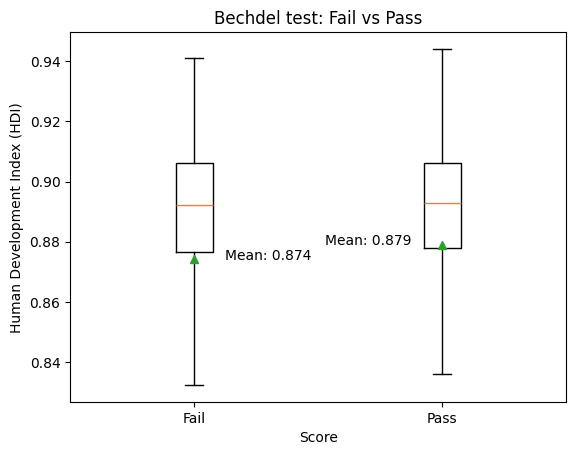

In [282]:
# Pass or Fail
bool_pass = (final_group_movies['bechdel_score']==3)
final_pass = final_group_movies[bool_pass]
final_pass_HDI = final_pass['Human Development Index']
final_fail = final_group_movies[~bool_pass]
final_fail_HDI = final_fail['Human Development Index']

fig, ax = plt.subplots()

# Boxplot
ax.boxplot([final_fail_HDI, final_pass_HDI], labels=['Fail','Pass'], showfliers=False, showmeans=True)

# Set labels and title
ax.set_xlabel('Score')
ax.set_ylabel('Human Development Index (HDI)')
ax.set_title('Bechdel test: Fail vs Pass')

# Print the quantity of Movies that Fail and Pass Bechdel Test 
print('Number of Fail: ' + str(len(final_fail)) + ' \nNumber of Pass: ' + str(len(final_pass)))

# Calculate the mean for each 
mean_fail_HDI = final_fail['Human Development Index'].mean()
mean_pass_HDI = final_pass['Human Development Index'].mean()

# Present the values in the graph
ax.text(1.3, mean_fail_HDI, 'Mean: ' + str(round(mean_fail_HDI,3)) , ha = 'center')
ax.text(1.7, mean_pass_HDI, 'Mean: ' + str(round(mean_pass_HDI,3)) , ha = 'center')

# Show the plot
plt.show()

We have 26 movies without GII data
Number of Fail: 1548 
Number of Pass: 2188


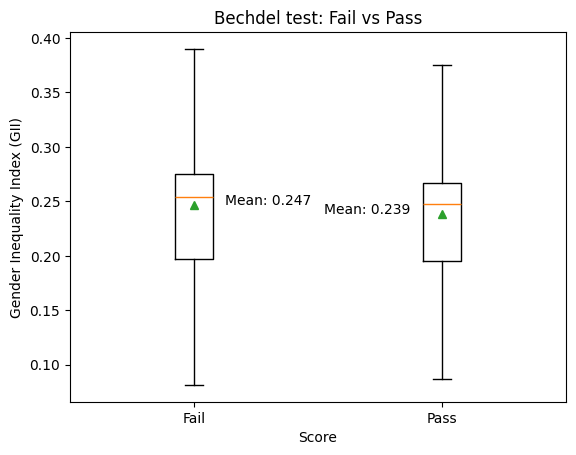

In [283]:
# Pass or Fail
# Take the GII values that are Nan
final_group_movies_GII = final_group_movies[~final_group_movies['Gender Inequality Index'].isna()]
diference_HDIvsGII = len(final_group_movies) - len(final_group_movies_GII)
print('We have ' + str(diference_HDIvsGII) + " movies without GII data")
bool_pass_GII = (final_group_movies_GII['bechdel_score']==3)
final_pass = final_group_movies_GII[bool_pass_GII]
final_pass_GII = final_pass['Gender Inequality Index']
final_fail = final_group_movies_GII[~bool_pass_GII]
final_fail_GII = final_fail['Gender Inequality Index']

fig, ax = plt.subplots()

# Boxplot
ax.boxplot([final_fail_GII, final_pass_GII], labels=['Fail','Pass'], showfliers=False, showmeans=True)

# Set labels and title
ax.set_xlabel('Score')
ax.set_ylabel('Gender Inequality Index (GII)')
ax.set_title('Bechdel test: Fail vs Pass')

# Print the quantity of Movies that Fail and Pass Bechdel Test 
print('Number of Fail: ' + str(len(final_fail)) + ' \nNumber of Pass: ' + str(len(final_pass)))

# Calculate the mean for each 
mean_fail_GII = final_fail['Gender Inequality Index'].mean()
mean_pass_GII = final_pass['Gender Inequality Index'].mean()

# Present the values in the graph
ax.text(1.3, mean_fail_GII, 'Mean: ' + str(round(mean_fail_GII,3)) , ha = 'center')
ax.text(1.7, mean_pass_GII, 'Mean: ' + str(round(mean_pass_GII,3)) , ha = 'center')

# Show the plot
plt.show()

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

## Random Forest for Bechdel Score Classification

To further integrate our new features and try to develop an estimator framework to estimate Bechdel score. The reason we opt for random forest is that it can be utilized as a threshold based classifier since our new features consist of thresholdable features, such as setting a threshold for female cast ratio. Also, another important aspect is that when constructing the forest with trees, the features as ranked based on their importance, from a bottom-to-top fashion. This can be further used as a feature selection method.



In [2]:
bechdel_movies = pd.read_csv('movie_metadata_all_features.csv')
print(bechdel_movies.columns)

rf_features = bechdel_movies[['actor_mention_score', 'female_ratio', 'gender_density', 'negative', 'neutral', 'positive',
       'polarity_blob', 'polarity_roberta', 'bechdel_score']]

rf_features = rf_features.dropna()

display(rf_features)
print("Total number of data points after dropping NaNs:", rf_features.shape[0])

rf_features = rf_features.to_numpy()
rf_labels = rf_features[:,-1]
rf_features = rf_features[:,:-1]

Index(['1. Wikipedia movie ID', '2. Freebase movie ID', '3. Movie name',
       '4. Movie release date', '5. Movie box office revenue',
       '6. Movie runtime', '7. Movie languages (Freebase ID:name tuples)',
       '8. Movie countries (Freebase ID:name tuples)',
       '9. Movie genres (Freebase ID:name tuples)', 'bechdel_score',
       'actor_mention_score', 'female_ratio', 'year', 'she', 'her', 'he',
       'his', 'gender_density', 'negative', 'neutral', 'positive',
       'polarity_blob', 'polarity_roberta', 'bechdel_binary'],
      dtype='object')


,actor_mention_score,female_ratio,gender_density,negative,neutral,positive,polarity_blob,polarity_roberta,bechdel_score
0,0.2500,0.150000,0.000000,0.048826,0.830560,0.120614,-0.006250,0.071788,3
1,0.5345,0.461538,0.333333,0.129004,0.691920,0.179076,0.124547,0.050073,3
2,0.2830,0.428571,0.240000,0.252773,0.634228,0.112999,0.103638,-0.139774,3
3,1.0000,0.250000,0.868421,0.331542,0.582415,0.086043,0.045837,-0.245499,3
4,0.2500,0.285714,0.600000,0.640489,0.336088,0.023423,-0.049902,-0.617066,2
...,...,...,...,...,...,...,...,...,...
3851,0.2222,0.294118,0.636364,0.333736,0.607674,0.058590,0.090317,-0.275146,3
3852,0.7500,0.235294,0.206897,0.384289,0.565830,0.049881,0.041294,-0.334408,1
3853,0.1667,0.454545,0.055556,0.131713,0.691487,0.176800,0.094097,0.045087,3
3854,0.5200,0.285714,0.206897,0.317630,0.585357,0.097013,0.062872,-0.220617,3


Total number of data points after dropping NaNs: 3856


We can try to visualize our label distribution of our dataset:

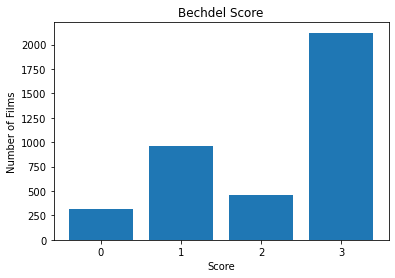

In [3]:
labels, counts = np.unique(rf_labels, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title('Bechdel Score')
plt.xlabel('Score')
plt.ylabel('Number of Films')

plt.show()

In [4]:
x_train, x_test, y_train, y_test = train_test_split(rf_features, rf_labels,test_size=0.3)

print("After train-test splitting:")
print("Training data shape:",x_train.shape,"\nTraining label shape:", y_train.shape, "\nTest data shape:",x_test.shape, "\nTest label shape",y_test.shape)

After train-test splitting:
Training data shape: (2699, 8) 
Training label shape: (2699,) 
Test data shape: (1157, 8) 
Test label shape (1157,)


In [5]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.6119273984442524


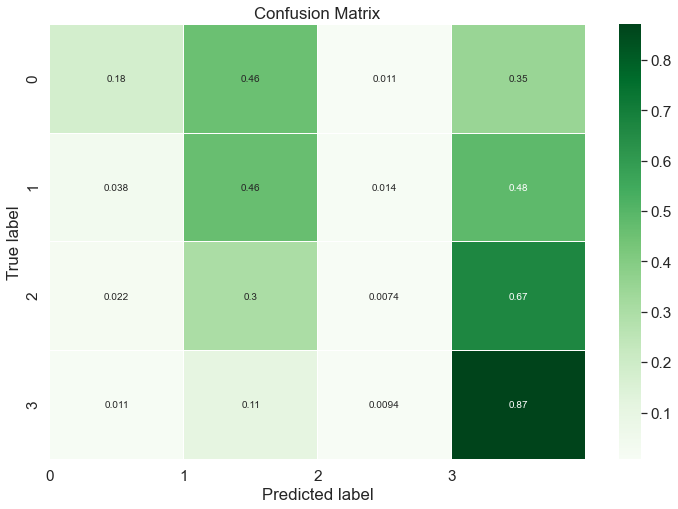

In [6]:
# Calculate and draw confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred).astype('float')
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)

class_names = ['0', '1', '2', '3']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [7]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.45      0.18      0.26        94
         1.0       0.46      0.46      0.46       287
         2.0       0.08      0.01      0.01       136
         3.0       0.68      0.87      0.76       640

    accuracy                           0.61      1157
   macro avg       0.42      0.38      0.37      1157
weighted avg       0.54      0.61      0.56      1157



## Unequal Classes! What about undersampling?

Before inspecting and analysing our preliminary results, first, let's try to carry out the same experiment with a different approach. Since the class distribution is not equal and bechdel score = 3 is the majority class, we can try to undersample the minority class, which is bechdel_score = 0. From each label, we can try to sample 300 samples each, in total 1200 samples, before the training and test split. This way, with the test accuracy and confusion matrix, we can interpret our results more easily and safely.


In [9]:
rf_features = bechdel_movies[['actor_mention_score', 'female_ratio', 'gender_density', 'negative', 'neutral', 'positive',
       'polarity_blob', 'polarity_roberta', 'bechdel_score']]

rf_features = rf_features.dropna()

print("Print before undersampling", rf_features['bechdel_score'].value_counts())
rf_features = rf_features.groupby('bechdel_score').apply(lambda x: x.sample(n=min(300, len(x))))
print("Print after undersampling", rf_features['bechdel_score'].value_counts())

display(rf_features)

rf_features = rf_features.to_numpy()
rf_labels = rf_features[:,-1]
rf_features = rf_features[:,:-1]

Print before undersampling bechdel_score
3    2122
1     957
2     464
0     313
Name: count, dtype: int64
Print after undersampling bechdel_score
0    300
1    300
2    300
3    300
Name: count, dtype: int64


actor_mention_score  female_ratio  gender_density  \
bechdel_score                                                           
0             723                1.0000      0.400000        0.363636   
              656                0.4118      0.133333        0.250000   
              1787               0.7742      0.454545        0.333333   
              1928               0.0000      0.100000        0.000000   
              2661               0.5000      0.090909        0.200000   
...                                 ...           ...             ...   
3             3297               0.0000      0.642857        1.000000   
              1034               0.5429      0.769231        0.666667   
              2923               0.7692      0.333333        0.750000   
              1717               0.6286      0.500000        0.695652   
              3543               0.7719      0.437500        0.829787   

                    negative   neutral  positive  polarity_blob  \
bechdel_score                                                     
0             723   0.338240  0.590314  0.071445       0.066300   
              656   0.324590  0.607794  0.067616       0.136890   
              1787  0.254311  0.679679  0.066010       0.092430   
              1928  0.341224  0.565882  0.092895       0.013812   
              2661  0.335329  0.574762  0.089909       0.065677   
...                      ...       ...       ...            ...   
3             3297  0.163804  0.667507  0.168690       0.291313   
              1034  0.411855  0.548630  0.039515       0.146018   
              2923  0.183710  0.609616  0.206675      -0.008033   
              1717  0.307204  0.604608  0.088188       0.086156   
              3543  0.302897  0.596386  0.100717       0.068182   

                    polarity_roberta  bechdel_score  
bechdel_score                                        
0             723          -0.266795              0  
              656          -0.256974              0  
              1787         -0.188301              0  
              1928         -0.248329              0  
              2661         -0.245420              0  
...                              ...            ...  
3             3297          0.004886              3  
              1034         -0.372340              3  
              2923          0.022965              3  
              1717         -0.219016              3  
              3543         -0.202179              3  

[1200 rows x 9 columns]

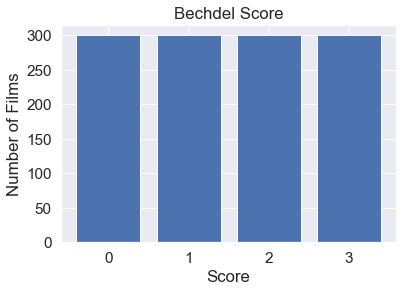

In [10]:
labels, counts = np.unique(rf_labels, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title('Bechdel Score')
plt.xlabel('Score')
plt.ylabel('Number of Films')

plt.show()

In [19]:
x_train, x_test, y_train, y_test = train_test_split(rf_features, rf_labels,test_size=0.3)

print("After train-test splitting:")
print("Training data shape:",x_train.shape,"\nTraining label shape:", y_train.shape, "\nTest data shape:",x_test.shape, "\nTest label shape",y_test.shape)

rf = RandomForestClassifier()
#rf_best = SelectFromModel(rf)
rf.fit(x_train, y_train)
#rf.get_support()

y_pred = rf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

After train-test splitting:
Training data shape: (840, 8) 
Training label shape: (840,) 
Test data shape: (360, 8) 
Test label shape (360,)
Test Accuracy: 0.4722222222222222


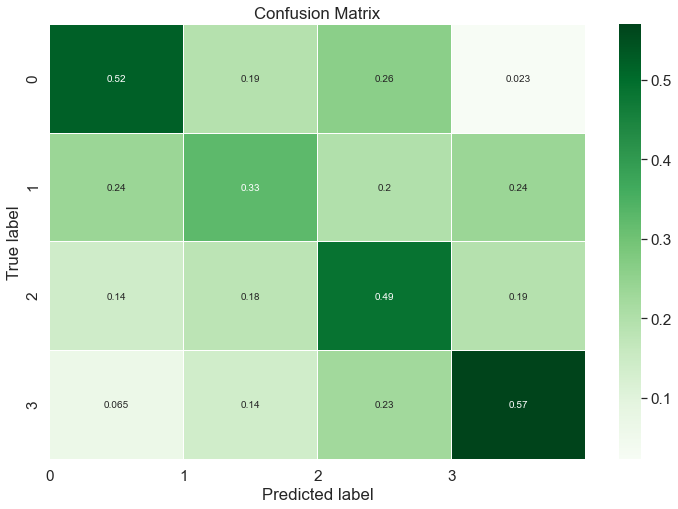

In [20]:
# Calculate and draw confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred).astype('float')
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)

class_names = ['0', '1', '2', '3']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.53      0.52      0.53        88
         1.0       0.43      0.33      0.37       101
         2.0       0.37      0.49      0.42        78
         3.0       0.56      0.57      0.57        93

    accuracy                           0.47       360
   macro avg       0.47      0.48      0.47       360
weighted avg       0.48      0.47      0.47       360



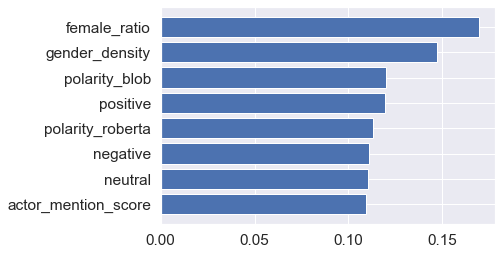

In [22]:
feature_names = ['actor_mention_score', 'female_ratio', 'gender_density', 'negative', 'neutral', 'positive',
       'polarity_blob', 'polarity_roberta', 'bechdel_score']

feature_importance = list(zip(feature_names, rf.feature_importances_))
feature_importance.sort(key = lambda x : x[1])

plt.barh([x[0] for x in feature_importance],[x[1] for x in feature_importance])
plt.show()

Considering the model with no information gained, we would consider %25 accuracy, whereas with the random forest, we get %46 test accuracy. This can be considering promising as well, compared to the %25 accuracy. Yet, this would not considered sufficient for a robust classifier. With the undersampled version, we eliminate the differentiation for precision, recall and F1 score. However, this not being a binary classification task, it would require more in-depth analysis for the individual classes. Looking for the confusion matrix, we release a significant difference between the accuracies of label 0 & 3 versus 1 & 2. Considering the definition of the Bechdel test, it is easy to classify score-0, cast not containing 2 female actresses. This can be deducted from female cast ratio.

We can visualize the how much each feature contributes to the estimator within the same function. We can rank and visualize feature importances in a bar plot. The random forest ranks the impurity of each features. As we can see from the figure above, from the trained random forest, we can see that the most importance is put on female cast ratio, and the second is gender pronoun density. The third place goes to polarity blob. The remaining seems to have more or less the same importance.

## Opting for Binary Bechdel Test

We observe that for the cases where the movie passes 1 or 2 tests, it is hard to classify. For this reason, we may opt to look from a more rigid perspective and binarize the output labels as "Passed", or "Failed". The same analysis is carried out with the binary bechdel version.

In [23]:
rf_features = bechdel_movies[['actor_mention_score', 'female_ratio', 'gender_density', 'negative', 'neutral', 'positive',
       'polarity_blob', 'polarity_roberta', 'bechdel_binary']]

rf_features = rf_features.dropna()

display(rf_features)

rf_features = rf_features.to_numpy()
rf_labels = rf_features[:,-1]
rf_features = rf_features[:,:-1]

,actor_mention_score,female_ratio,gender_density,negative,neutral,positive,polarity_blob,polarity_roberta,bechdel_binary
0,0.2500,0.150000,0.000000,0.048826,0.830560,0.120614,-0.006250,0.071788,1
1,0.5345,0.461538,0.333333,0.129004,0.691920,0.179076,0.124547,0.050073,1
2,0.2830,0.428571,0.240000,0.252773,0.634228,0.112999,0.103638,-0.139774,1
3,1.0000,0.250000,0.868421,0.331542,0.582415,0.086043,0.045837,-0.245499,1
4,0.2500,0.285714,0.600000,0.640489,0.336088,0.023423,-0.049902,-0.617066,0
...,...,...,...,...,...,...,...,...,...
3851,0.2222,0.294118,0.636364,0.333736,0.607674,0.058590,0.090317,-0.275146,1
3852,0.7500,0.235294,0.206897,0.384289,0.565830,0.049881,0.041294,-0.334408,0
3853,0.1667,0.454545,0.055556,0.131713,0.691487,0.176800,0.094097,0.045087,1
3854,0.5200,0.285714,0.206897,0.317630,0.585357,0.097013,0.062872,-0.220617,1


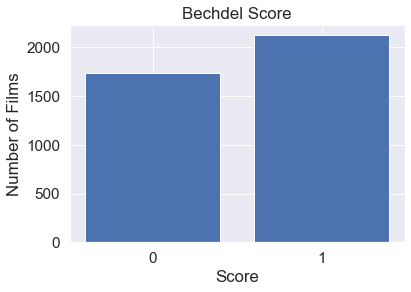

In [24]:
labels, counts = np.unique(rf_labels, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title('Bechdel Score')
plt.xlabel('Score')
plt.ylabel('Number of Films')

plt.show()

In [25]:
x_train, x_test, y_train, y_test = train_test_split(rf_features, rf_labels,test_size=0.3)

print("After train-test splitting:")
print("Training data shape:",x_train.shape,"\nTraining label shape:", y_train.shape, "\nTest data shape:",x_test.shape, "\nTest label shape",y_test.shape)

rf = RandomForestClassifier(n_estimators = 100)
#rf_best = SelectFromModel(rf)
rf.fit(x_train, y_train)
#rf.get_support()

y_pred = rf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

After train-test splitting:
Training data shape: (2699, 8) 
Training label shape: (2699,) 
Test data shape: (1157, 8) 
Test label shape (1157,)
Test Accuracy: 0.7182368193604148


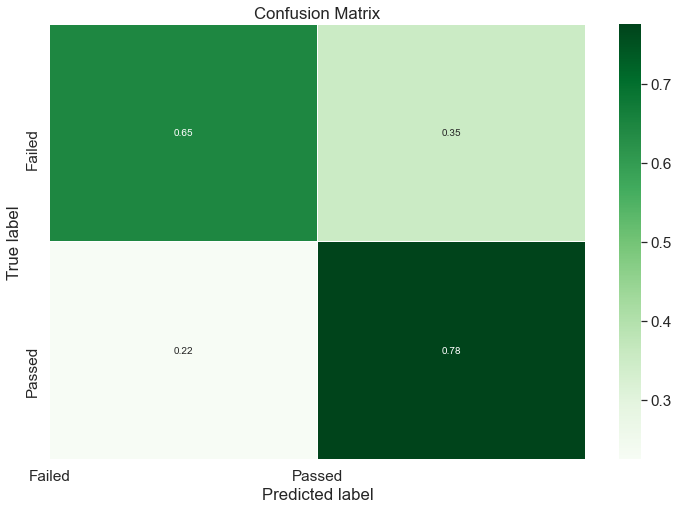

In [26]:
# Calculate and draw confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred).astype('float')
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)

class_names = ['Failed', 'Passed']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.65      0.67       515
         1.0       0.73      0.78      0.75       642

    accuracy                           0.72      1157
   macro avg       0.72      0.71      0.71      1157
weighted avg       0.72      0.72      0.72      1157



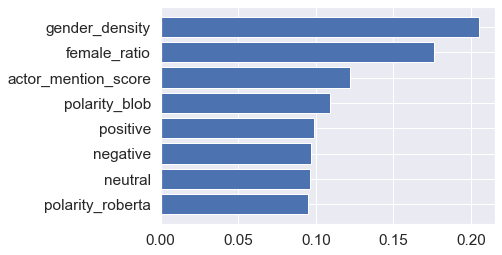

In [28]:
feature_names = ['actor_mention_score', 'female_ratio', 'gender_density', 'negative', 'neutral', 'positive',
       'polarity_blob', 'polarity_roberta', 'bechdel_binary']

feature_importance = list(zip(feature_names, rf.feature_importances_))
feature_importance.sort(key = lambda x : x[1])

plt.barh([x[0] for x in feature_importance],[x[1] for x in feature_importance])
plt.show()

## Binary Bechdel with Undersampling

In [30]:
rf_features = bechdel_movies[['actor_mention_score', 'female_ratio', 'gender_density', 'negative', 'neutral', 'positive',
       'polarity_blob', 'polarity_roberta', 'bechdel_binary']]


rf_features = rf_features.dropna()

print("Print before undersampling", rf_features['bechdel_binary'].value_counts())
rf_features = rf_features.groupby('bechdel_binary').apply(lambda x: x.sample(n=min(1700, len(x))))
print("Print after undersampling", rf_features['bechdel_binary'].value_counts())

display(rf_features)

rf_features = rf_features.to_numpy()
rf_labels = rf_features[:,-1]
rf_features = rf_features[:,:-1]

Print before undersampling bechdel_binary
1    2122
0    1734
Name: count, dtype: int64
Print after undersampling bechdel_binary
0    1700
1    1700
Name: count, dtype: int64


actor_mention_score  female_ratio  gender_density  \
bechdel_binary                                                           
0              3292               0.2931      0.100000        0.309524   
               1152               0.4242      0.153846        0.450000   
               1888               0.0000      0.142857        0.000000   
               1794               0.0000      0.666667        0.136364   
               1650               0.5000      0.384615        0.100000   
...                                  ...           ...             ...   
1              829                0.7692      0.500000        0.763636   
               3407               0.3253      0.500000        0.410256   
               3399               0.6667      0.500000        0.480000   
               1057               0.0278      0.461538        0.303030   
               2909               0.4194      0.562500        0.200000   

                     negative   neutral  positive  polarity_blob  \
bechdel_binary                                                     
0              3292  0.244804  0.643643  0.111553       0.076359   
               1152  0.373179  0.590507  0.036314      -0.028448   
               1888  0.427230  0.469574  0.103196       0.045225   
               1794  0.350868  0.563257  0.085875       0.003311   
               1650  0.520902  0.448112  0.030986       0.064345   
...                       ...       ...       ...            ...   
1              829   0.368028  0.560008  0.071964      -0.069899   
               3407  0.594799  0.368836  0.036365       0.020300   
               3399  0.161032  0.728505  0.110463       0.109161   
               1057  0.314384  0.604895  0.080721      -0.003141   
               2909  0.258440  0.605264  0.136295       0.116015   

                     polarity_roberta  bechdel_binary  
bechdel_binary                                         
0              3292         -0.133252               0  
               1152         -0.336865               0  
               1888         -0.324034               0  
               1794         -0.264993               0  
               1650         -0.489916               0  
...                               ...             ...  
1              829          -0.296064               1  
               3407         -0.558435               1  
               3399         -0.050569               1  
               1057         -0.233663               1  
               2909         -0.122145               1  

[3400 rows x 9 columns]

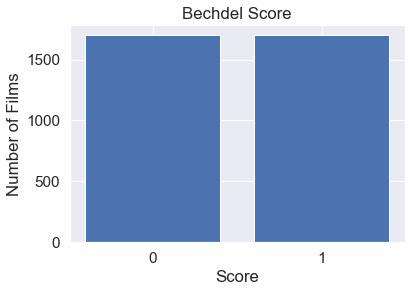

In [31]:
labels, counts = np.unique(rf_labels, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title('Bechdel Score')
plt.xlabel('Score')
plt.ylabel('Number of Films')

plt.show()

In [32]:
x_train, x_test, y_train, y_test = train_test_split(rf_features, rf_labels,test_size=0.3)

print("After train-test splitting:")
print("Training data shape:",x_train.shape,"\nTraining label shape:", y_train.shape, "\nTest data shape:",x_test.shape, "\nTest label shape",y_test.shape)

rf = RandomForestClassifier(n_estimators = 100)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

After train-test splitting:
Training data shape: (2380, 8) 
Training label shape: (2380,) 
Test data shape: (1020, 8) 
Test label shape (1020,)
Test Accuracy: 0.7166666666666667


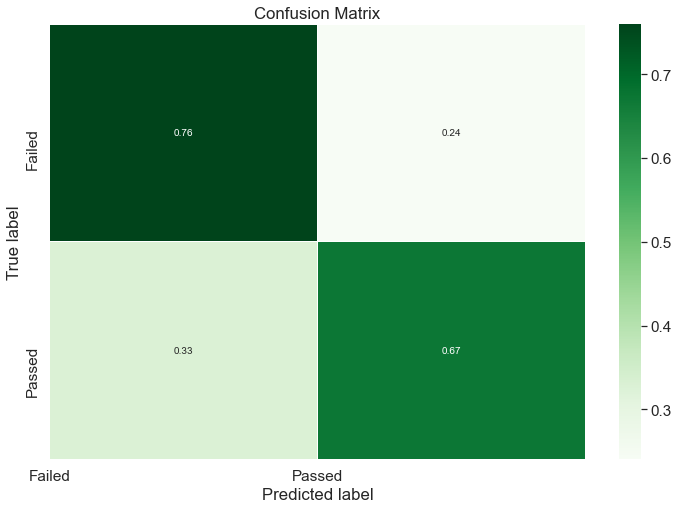

In [33]:
# Calculate and draw confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred).astype('float')
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)

class_names = ['Failed', 'Passed']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.76      0.73       524
         1.0       0.73      0.67      0.70       496

    accuracy                           0.72      1020
   macro avg       0.72      0.72      0.72      1020
weighted avg       0.72      0.72      0.72      1020



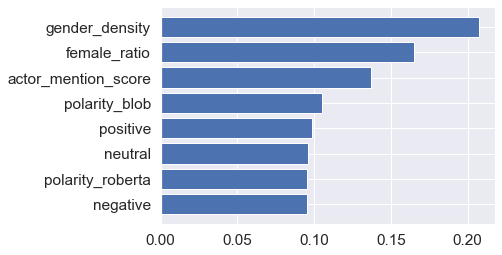

In [35]:
feature_names = ['actor_mention_score', 'female_ratio', 'gender_density', 'negative', 'neutral', 'positive',
       'polarity_blob', 'polarity_roberta', 'bechdel_binary']

feature_importance = list(zip(feature_names, rf.feature_importances_))
feature_importance.sort(key = lambda x : x[1])

plt.barh([x[0] for x in feature_importance],[x[1] for x in feature_importance])
plt.show()

Although this does not provide us very crucial information, we can still try to get some information on the nature of the Bechdel test. We can see that our test accuracy raises to %71, from %50 with the random guessing case. Comparing the feature importance scores with the complete Bechdel classes, we can see that the first two features are still the same. The actor mention score seems to gain more importance this time. The rest does not provide us crucial information.

## Final Recipe for Bechdel Classifier:

For the final recipe, we can eliminate the intermediate features such as positive sentiment probability, negative sentiment probability, etc. 

The final features kept are the folowings:
* Actor Mention Score
* Female Cast Ratio
* Gender Pronoun Density
* Polarity Blob

Using these features, we can train our classifier for the one lsat time:


In [36]:
rf_features = bechdel_movies[['actor_mention_score', 'female_ratio', 'gender_density',
       'polarity_blob', 'bechdel_score']]

rf_features = rf_features.dropna()

print("Print before undersampling", rf_features['bechdel_score'].value_counts())
rf_features = rf_features.groupby('bechdel_score').apply(lambda x: x.sample(n=min(300, len(x))))
print("Print after undersampling", rf_features['bechdel_score'].value_counts())

display(rf_features)

rf_features = rf_features.to_numpy()
rf_labels = rf_features[:,-1]
rf_features = rf_features[:,:-1]

Print before undersampling bechdel_score
3    2122
1     957
2     464
0     313
Name: count, dtype: int64
Print after undersampling bechdel_score
0    300
1    300
2    300
3    300
Name: count, dtype: int64


actor_mention_score  female_ratio  gender_density  \
bechdel_score                                                           
0             95                 0.2000      0.125000        0.350000   
              2565               0.8333      0.200000        0.416667   
              842                0.0000      0.000000        0.000000   
              1788               1.0000      1.000000        0.809524   
              2192               0.1613      0.230769        0.000000   
...                                 ...           ...             ...   
3             2873               0.4576      0.500000        0.676471   
              2919               0.4167      0.416667        0.641791   
              2126               0.4314      0.583333        0.540146   
              2099               0.8000      0.500000        1.000000   
              1967               0.3750      0.333333        0.257143   

                    polarity_blob  bechdel_score  
bechdel_score                                     
0             95         0.041537              0  
              2565      -0.093061              0  
              842        0.048781              0  
              1788       0.213889              0  
              2192       0.053166              0  
...                           ...            ...  
3             2873       0.073796              3  
              2919       0.010951              3  
              2126       0.033065              3  
              2099       0.035714              3  
              1967       0.157576              3  

[1200 rows x 5 columns]

In [55]:
x_train, x_test, y_train, y_test = train_test_split(rf_features, rf_labels,test_size=0.3)

print("After train-test splitting:")
print("Training data shape:",x_train.shape,"\nTraining label shape:", y_train.shape, "\nTest data shape:",x_test.shape, "\nTest label shape",y_test.shape)

rf = RandomForestClassifier()
#rf_best = SelectFromModel(rf)
rf.fit(x_train, y_train)
#rf.get_support()

y_pred = rf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

After train-test splitting:
Training data shape: (840, 4) 
Training label shape: (840,) 
Test data shape: (360, 4) 
Test label shape (360,)
Test Accuracy: 0.44722222222222224


In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.52      0.57      0.54        86
         1.0       0.34      0.34      0.34        89
         2.0       0.39      0.31      0.34        97
         3.0       0.53      0.59      0.56        88

    accuracy                           0.45       360
   macro avg       0.44      0.45      0.44       360
weighted avg       0.44      0.45      0.44       360



We can see that we still get almost the same test accuracy but less features for the desired task. The small difference can be attributed to random state of the classifier.